In [ ]:
!pip install sentinelhub
!pip install sentinelsat
!pip install rasterio
!pip install geopandas
!pip install skimage
!pip install gdal

     |████████████████████████████████| 184kB 8.4MB/s 
     |████████████████████████████████| 10.9MB 16.6MB/s 
     |████████████████████████████████| 51kB 8.1MB/s 
  Created wheel for sentinelhub: filename=sentinelhub-3.0.5-cp36-none-any.whl size=187743 sha256=ac93894844cac18a122d4557ad63fbe60f0823178444bee3180d856f430e7f9b
  Stored in directory: /root/.cache/pip/wheels/26/7a/9b/05e508fb080ef7e27da59f68e3cceb895807df3788bc07a88a
  Created wheel for utm: filename=utm-0.6.0-cp36-none-any.whl size=6095 sha256=b0bff474f848f8fdd6d31011a283b6d2abbad701556c0fe50e1df8e1dbcfcb3f
  Stored in directory: /root/.cache/pip/wheels/9a/76/b2/58ad7ade8b0475c577f80ee8023d7164fd561bb45c20b4beab
Successfully built sentinelhub utm
     |████████████████████████████████| 18.2MB 164kB/s 
     |████████████████████████████████| 972kB 8.8MB/s 
     |████████████████████████████████| 14.8MB 209kB/s 
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [ ]:
!pip install opencv-python

In [ ]:
from sentinelsat.sentinel import SentinelAPI, read_geojson, geojson_to_wkt
import torch
import torchvision
from torch.utils.data import *
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import PIL as PIL
from PIL import Image
import torchvision.models as models
from matplotlib import cm
import cv2
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
from skimage import exposure
import time
import copy
import os, sys
import scipy as N
import gdal
import rasterio
from rasterio.windows import Window
from rasterio import plot
from datetime import date
import getpass
import pandas as pd
import math
import re
import geopandas as gpd
from matplotlib import pyplot as plt
import shutil
%matplotlib inline



In [ ]:
# connect to the API
user = 'sajeelh581'
# user = input('Sentinel Hub Username: ')
pw = getpass.getpass('9G2fujf4')
api = SentinelAPI(user, pw, 'https://scihub.copernicus.eu/dhus')

9G2fujf4··········


In [ ]:
geo_json = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "type": "Polygon",
        "coordinates": [
          [
            [
              72.83660888671875,
              33.51391942394942
            ],
            [
              73.23211669921875,
              33.51391942394942
            ],
            [
              73.23211669921875,
              33.7825716472443
            ],
            [
              72.83660888671875,
              33.7825716472443
            ],
            [
              72.83660888671875,
              33.51391942394942
            ]
          ]
        ]
      }
    }
  ]
}

In [ ]:

footprint = geojson_to_wkt(geo_json)
products_S2 = api.query(footprint,
                     date = ('20200301', date(2020, 8, 31)),
                     platformname = 'Sentinel-2',
                     cloudcoverpercentage = (0, 20))



In [ ]:
s2_res_df = api.download_all(products_S2,'./drive/My Drive/Datasets/Project/zipFiles')

In [ ]:
import zipfile
for root,_,files in os.walk(os.path.join('./drive/My Drive/Datasets/Project/zipFiles/')):
    for filename in files:
      zip_ref = zipfile.ZipFile(os.path.join(root,filename), 'r')
      zip_ref.extractall(os.path.join('./drive/My Drive/Datasets/Project', 's2_files'))
      zip_ref.close()
      os.remove(os.path.join(root,filename))


In [ ]:
!rm -r './drive/My Drive/Datasets/Project/zipFiles/'

In [ ]:
def createTrueColorImage(bands,name,count,xoffset,yoffset,width,height):
  trueColor = rasterio.open('./drive/My Drive/Datasets/Project/tiffFiles/{}.tiff'.format(name),'w',driver='GTiff',
                          width=width,height=height,
                          count=count,
                          crs=bands['B04'].crs,
                          transform=bands['B04'].transform,
                          dtype=bands['B04'].dtypes[0],
                          )
  trueColor.write(bands['B02'].read(1, window=Window(xoffset,yoffset,width,height)),3) #blue
  trueColor.write(bands['B03'].read(1, window=Window(xoffset,yoffset,width,height)),2) #green
  trueColor.write(bands['B04'].read(1, window=Window(xoffset,yoffset,width,height)),1) #red
  trueColor.write(bands['B05'].read(1, window=Window(xoffset,yoffset,width,height)),4) 
  trueColor.write(bands['B06'].read(1, window=Window(xoffset,yoffset,width,height)),5)
  trueColor.write(bands['B07'].read(1, window=Window(xoffset,yoffset,width,height)),6)
  trueColor.write(bands['B08'].read(1, window=Window(xoffset,yoffset,width,height)),7) 
  trueColor.write(bands['B8A'].read(1, window=Window(xoffset,yoffset,width,height)),8)
  trueColor.write(bands['B09'].read(1, window=Window(xoffset,yoffset,width,height)),9)
  if 'B10' in bands:
    trueColor.write(bands['B10'].read(1, window=Window(xoffset,yoffset,width,height)),10) 
    trueColor.write(bands['B11'].read(1, window=Window(xoffset,yoffset,width,height)),11)
    trueColor.write(bands['B12'].read(1, window=Window(xoffset,yoffset,width,height)),12) 
  else:
    trueColor.write(bands['B11'].read(1, window=Window(xoffset,yoffset,width,height)),10)
    trueColor.write(bands['B12'].read(1, window=Window(xoffset,yoffset,width,height)),11) 
  trueColor.close()
  



In [ ]:
sentinelName = [f.name for f in os.scandir('./drive/My Drive/Datasets/Project/s2_files/') if f.is_dir()]
rootPath = './drive/My Drive/Datasets/Project/s2_files/'

In [ ]:
 bands = {}
for i in range(len(sentinelName)):
  print(sentinelName[i])
  bands = {}
  for root,dirs,files in os.walk(os.path.join(rootPath,sentinelName[i],'GRANULE')):
    for name in files:
      if re.search('B02\.jp2',name) or re.search('B02_10m\.jp2',name):
        bands['B02'] = rasterio.open(os.path.join(root,name),driver='JP2OpenJPEG')
      if re.search('B03\.jp2',name) or re.search('B03_10m\.jp2',name):
        bands['B03'] = rasterio.open(os.path.join(root,name),driver='JP2OpenJPEG')
      if re.search('B04\.jp2',name) or re.search('B04_10m\.jp2',name):
        bands['B04'] = rasterio.open(os.path.join(root,name),driver='JP2OpenJPEG')
      if re.search('B05\.jp2',name) or re.search('B05_20m\.jp2',name):
        bands['B05'] = rasterio.open(os.path.join(root,name),driver='JP2OpenJPEG')
      if re.search('B06\.jp2',name) or re.search('B06_20m\.jp2',name):
        bands['B06'] = rasterio.open(os.path.join(root,name),driver='JP2OpenJPEG')
      if re.search('B07\.jp2',name) or re.search('B07_20m\.jp2',name):
        bands['B07'] = rasterio.open(os.path.join(root,name),driver='JP2OpenJPEG')
      if re.search('B08\.jp2',name) or re.search('B08_10m\.jp2',name):
        bands['B08'] = rasterio.open(os.path.join(root,name),driver='JP2OpenJPEG') 
      if re.search('B8A\.jp2',name) or re.search('B8A_20m\.jp2',name):
        bands['B8A'] = rasterio.open(os.path.join(root,name),driver='JP2OpenJPEG')
      if re.search('B09\.jp2',name) or re.search('B09_60m\.jp2',name):
        bands['B09'] = rasterio.open(os.path.join(root,name),driver='JP2OpenJPEG')
      if re.search('B10\.jp2',name) or re.search('B10_20m\.jp2',name):
        bands['B10'] = rasterio.open(os.path.join(root,name),driver='JP2OpenJPEG')
      if re.search('B11\.jp2',name) or re.search('B11_20m\.jp2',name):
        bands['B11'] = rasterio.open(os.path.join(root,name),driver='JP2OpenJPEG')
      if re.search('B12\.jp2',name) or re.search('B12_20m\.jp2',name):
        bands['B12'] = rasterio.open(os.path.join(root,name),driver='JP2OpenJPEG')
  createTrueColorImage(bands,sentinelName[i][:-5],len(bands),500,6200,2496,1536)


S2B_MSIL1C_20200823T054639_N0209_R048_T43SBT_20200823T074854.SAFE
S2B_MSIL1C_20200823T054639_N0209_R048_T43SCT_20200823T074854.SAFE
S2B_MSIL1C_20200813T054639_N0209_R048_T43SBT_20200813T075430.SAFE
S2B_MSIL2A_20200803T054639_N0214_R048_T43SBT_20200804T154636.SAFE
S2B_MSIL1C_20200803T054639_N0209_R048_T43SBT_20200804T150456.SAFE
S2B_MSIL1C_20200803T054639_N0209_R048_T43SCT_20200804T150456.SAFE
S2A_MSIL2A_20200729T054641_N0214_R048_T43SCT_20200729T101649.SAFE
S2A_MSIL2A_20200729T054641_N0214_R048_T43SBT_20200729T101649.SAFE
S2A_MSIL1C_20200729T054641_N0209_R048_T43SCT_20200729T085637.SAFE
S2A_MSIL1C_20200729T054641_N0209_R048_T43SBT_20200729T085637.SAFE
S2A_MSIL2A_20200719T054641_N0214_R048_T43SBT_20200719T091704.SAFE
S2A_MSIL1C_20200719T054641_N0209_R048_T43SBT_20200719T083139.SAFE
S2B_MSIL2A_20200714T054639_N0214_R048_T43SBT_20200714T104330.SAFE
S2B_MSIL2A_20200714T054639_N0214_R048_T43SCT_20200714T104330.SAFE
S2B_MSIL1C_20200714T054639_N0209_R048_T43SBT_20200714T094320.SAFE
S2B_MSIL1C

In [ ]:
!rm -r './drive/My Drive/Datasets/Project/s2_files/*'

rm: cannot remove './drive/My Drive/Datasets/Project/s2_files/*': No such file or directory


In [ ]:
def processCropSaveImage(path,xoffset,yoffset,width,height,dest,name,index):
  with rasterio.open(path,count=12) as src:
    image = np.array(src.read(window=Window(xoffset, yoffset, width, height)))
    #Commented out for ground truth cropping
    # p2, p98 = np.percentile(image,(2,98))
    # image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000
    rgb = ((np.clip(image.copy(),0,1))*65535).astype('uint16')
    cropped = rasterio.open('{}{}_{}.tiff'.format(dest,name,index),'w',driver='GTiff',
                          width=224, height=224,
                          count=src.count,
                          crs=src.crs,
                          dtype=src.dtypes[0],
                          )
    cropped.write(rgb)
    cropped.close()

    return rgb

In [ ]:
def showTiffImage(path):
  with rasterio.open(path,count=3) as src:
    w_1 = src.read(1)
    w_2 = src.read(2)
    w_3 = src.read(3)
    image = np.array([w_1,w_2,w_3])
    p2, p98 = np.percentile(image,(2,98))
    image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000
    return image

In [ ]:
root = './drive/My Drive/Datasets/Project/tiffFiles/'
imgNames = [f.name for f in os.scandir('./drive/My Drive/Datasets/Project/tiffFiles/')]
groundTruthPngPath = './drive/My Drive/Datasets/Project/Ground_Truth_Final.png'
groundTruthTiffPath = './drive/My Drive/Datasets/Project/groundTruth/'


In [ ]:
img = np.asarray(Image.open(groundTruthPath))
img = np.transpose(img,(2,0,1))

# srcImg = showTiffImage(os.path.join(root,imgNames[0]))
# groundTruth = srcImg * img[0]
# plot.show(groundTruth)
# print(groundTruth)

with rasterio.open(os.path.join(root,imgNames[0]),count=11) as src:
  groundTruth = src.read() * img[0]
  modified = rasterio.open('{}annotation.tiff'.format(groundTruthTiffPath),'w',driver='GTiff',
                          width=src.width, height=src.height,
                          count=src.count,
                          crs=src.crs,
                          dtype=src.dtypes[0],
                          )
  modified.write(groundTruth)
  modified.close()

/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:232: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  **kwargs)


In [ ]:
!rm -r './drive/My Drive/Datasets/Project/croppedGroundTruth/'

/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


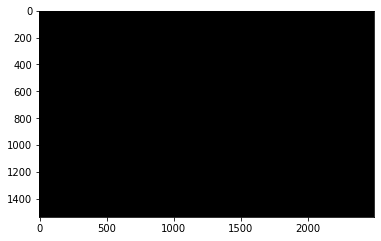

In [ ]:
plot.show(showTiffImage('./drive/My Drive/Datasets/Project/groundTruth/annotation.tiff'))

/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(11, 224, 224) AnnotatedCrop_0_0_0


/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:232: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  **kwargs)


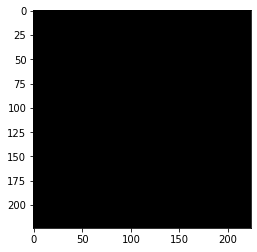

(11, 224, 224) AnnotatedCrop_0_0_1


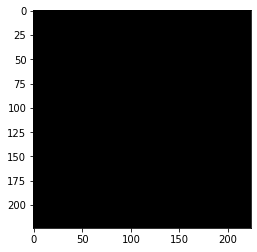

(11, 224, 224) AnnotatedCrop_0_0_2


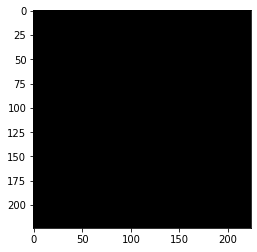

(11, 224, 224) AnnotatedCrop_0_0_3


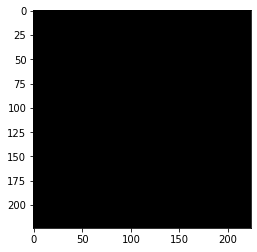

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_0_0_4


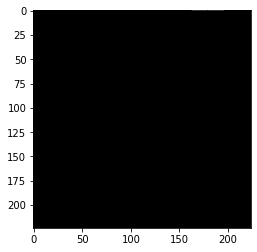

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_0_0_5


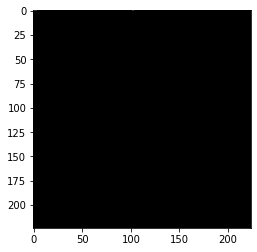

(11, 224, 224) AnnotatedCrop_0_0_6


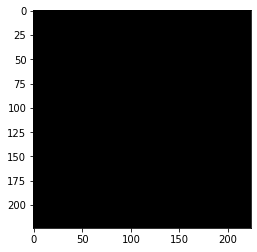

(11, 224, 224) AnnotatedCrop_0_0_7


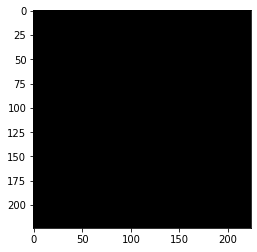

(11, 224, 224) AnnotatedCrop_0_0_8


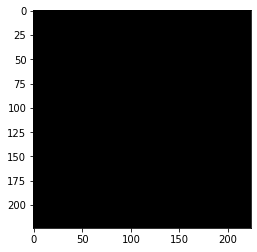

(11, 224, 224) AnnotatedCrop_0_0_9


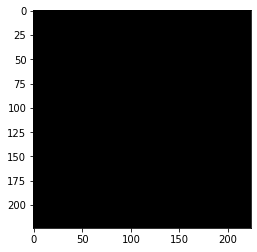

(11, 224, 224) AnnotatedCrop_0_0_10


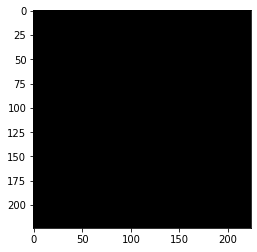

(11, 224, 224) AnnotatedCrop_0_0_11


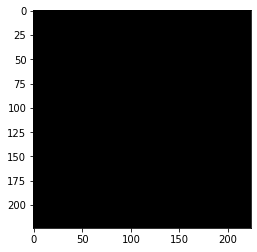

(11, 224, 192) AnnotatedCrop_0_0_12


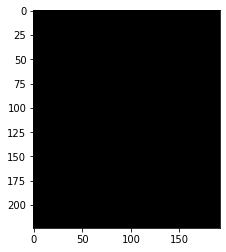

(11, 224, 224) AnnotatedCrop_0_1_0


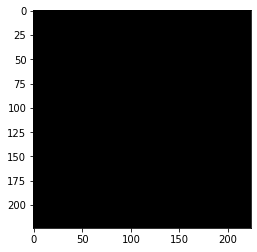

(11, 224, 224) AnnotatedCrop_0_1_1


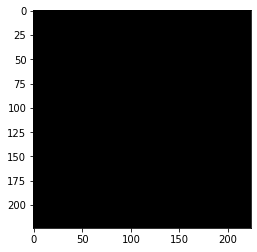

(11, 224, 224) AnnotatedCrop_0_1_2


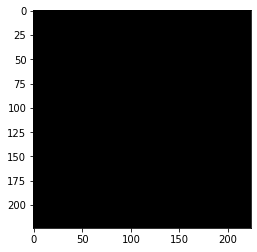

(11, 224, 224) AnnotatedCrop_0_1_3


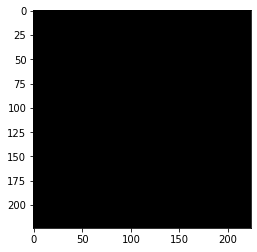

(11, 224, 224) AnnotatedCrop_0_1_4


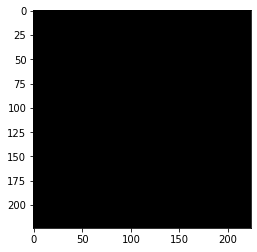

(11, 224, 224) AnnotatedCrop_0_1_5


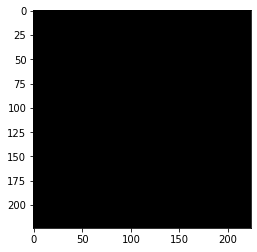

(11, 224, 224) AnnotatedCrop_0_1_6


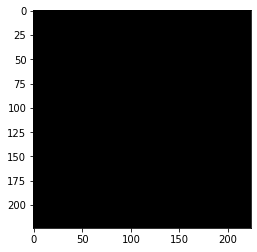

(11, 224, 224) AnnotatedCrop_0_1_7


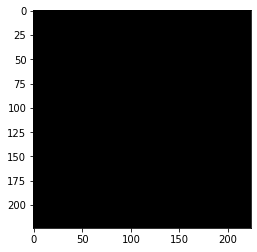

(11, 224, 224) AnnotatedCrop_0_1_8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


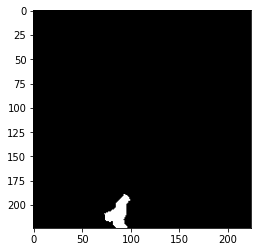

(11, 224, 224) AnnotatedCrop_0_1_9


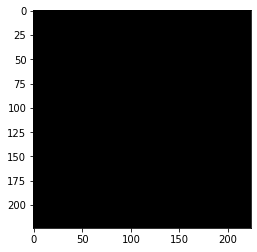

(11, 224, 224) AnnotatedCrop_0_1_10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


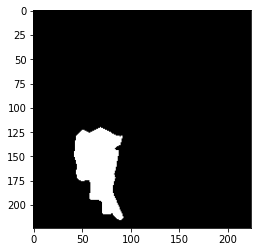

(11, 224, 224) AnnotatedCrop_0_1_11


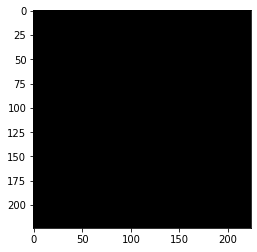

(11, 224, 192) AnnotatedCrop_0_1_12


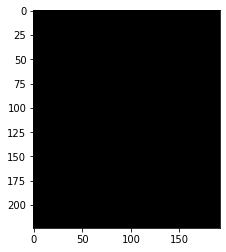

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_0_2_0


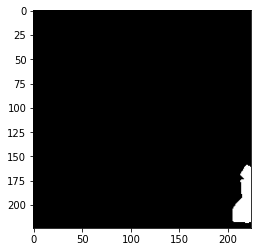

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_0_2_1


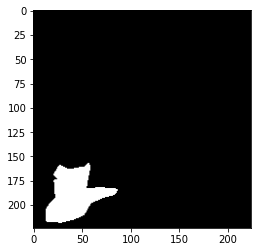

(11, 224, 224) AnnotatedCrop_0_2_2


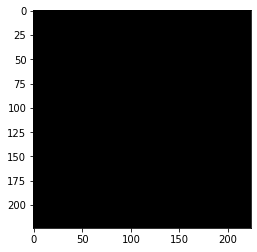

(11, 224, 224) AnnotatedCrop_0_2_3


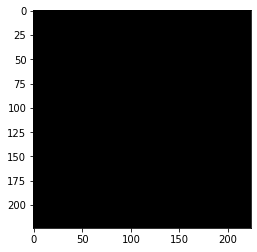

(11, 224, 224) AnnotatedCrop_0_2_4


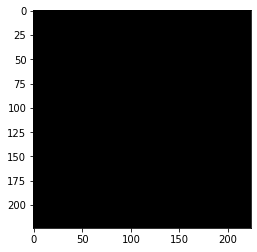

(11, 224, 224) AnnotatedCrop_0_2_5


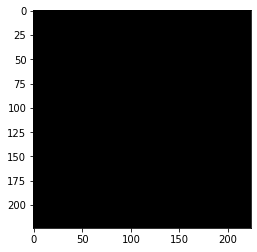

(11, 224, 224) AnnotatedCrop_0_2_6


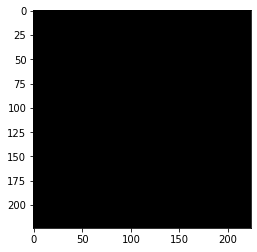

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_0_2_7


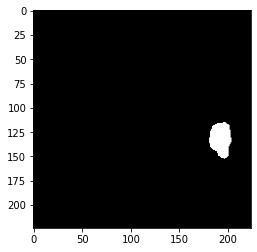

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_0_2_8


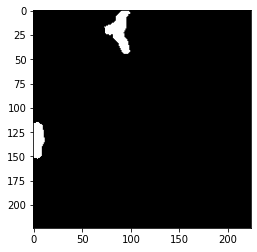

(11, 224, 224) AnnotatedCrop_0_2_9


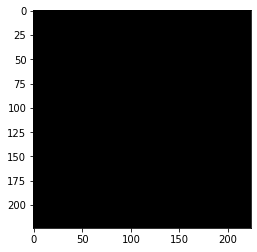

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_0_2_10


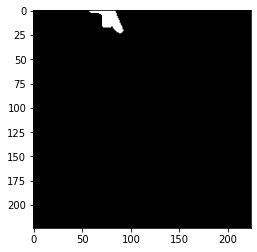

(11, 224, 224) AnnotatedCrop_0_2_11


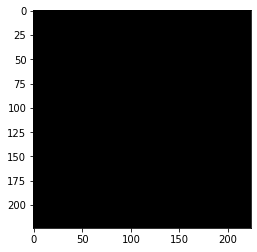

(11, 224, 192) AnnotatedCrop_0_2_12


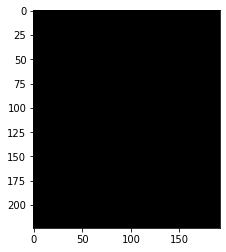

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_0_3_0


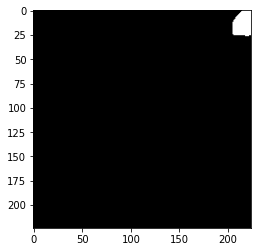

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_0_3_1


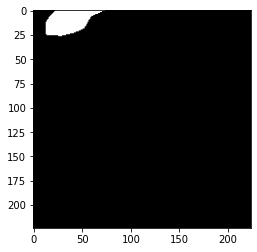

(11, 224, 224) AnnotatedCrop_0_3_2


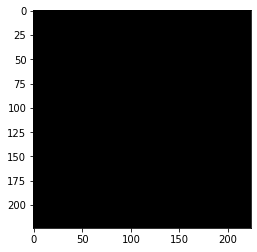

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_0_3_3


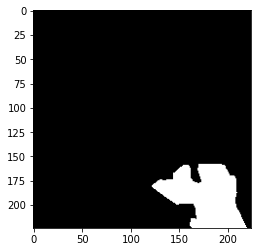

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_0_3_4


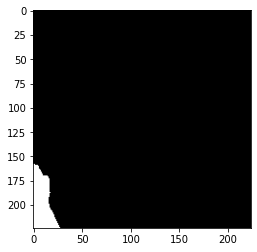

(11, 224, 224) AnnotatedCrop_0_3_5


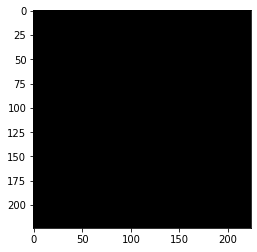

(11, 224, 224) AnnotatedCrop_0_3_6


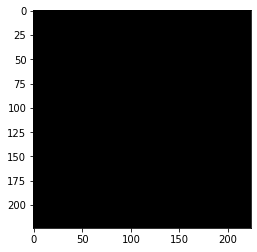

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_0_3_7


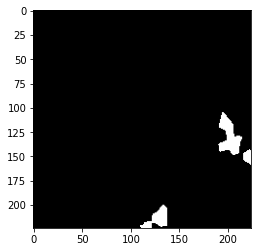

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_0_3_8


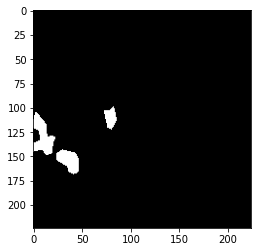

(11, 224, 224) AnnotatedCrop_0_3_9


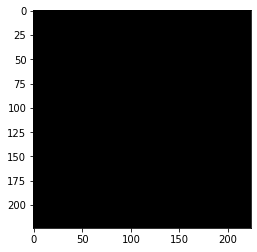

(11, 224, 224) AnnotatedCrop_0_3_10


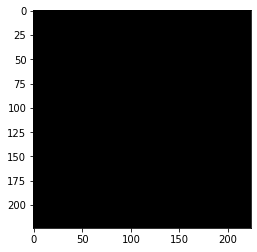

(11, 224, 224) AnnotatedCrop_0_3_11


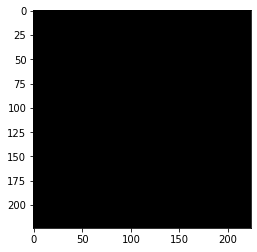

(11, 224, 192) AnnotatedCrop_0_3_12


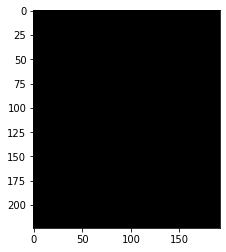

(11, 224, 224) AnnotatedCrop_0_4_0


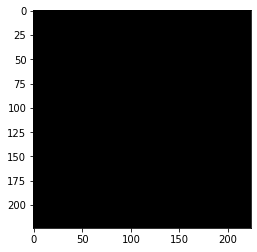

(11, 224, 224) AnnotatedCrop_0_4_1


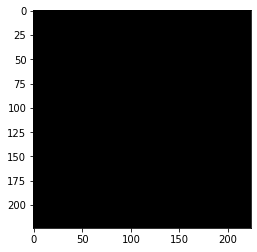

(11, 224, 224) AnnotatedCrop_0_4_2


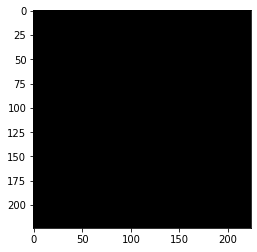

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_0_4_3


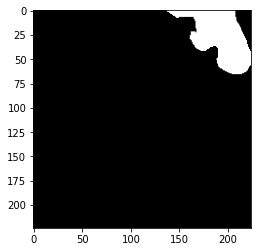

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_0_4_4


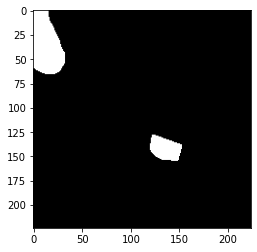

(11, 224, 224) AnnotatedCrop_0_4_5


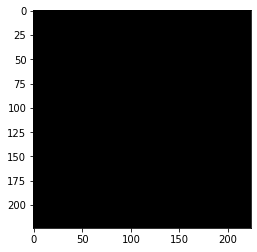

(11, 224, 224) AnnotatedCrop_0_4_6


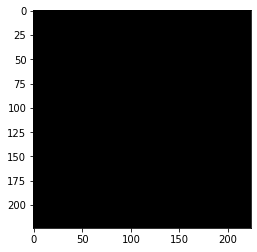

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_0_4_7


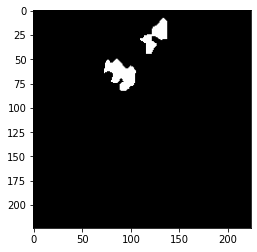

(11, 224, 224) AnnotatedCrop_0_4_8


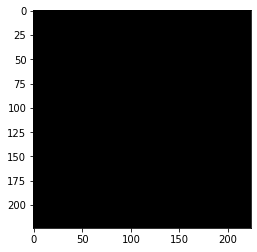

(11, 224, 224) AnnotatedCrop_0_4_9


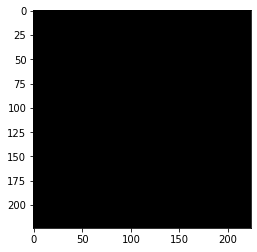

(11, 224, 224) AnnotatedCrop_0_4_10


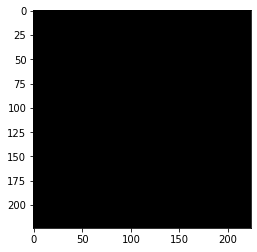

(11, 224, 224) AnnotatedCrop_0_4_11


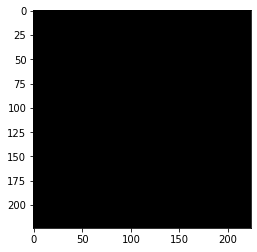

(11, 224, 192) AnnotatedCrop_0_4_12


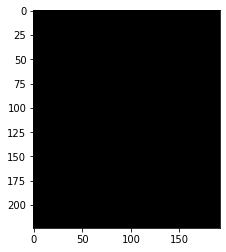

(11, 224, 224) AnnotatedCrop_0_5_0


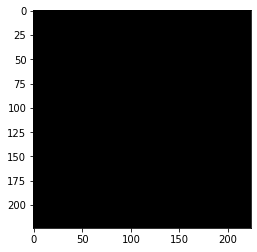

(11, 224, 224) AnnotatedCrop_0_5_1


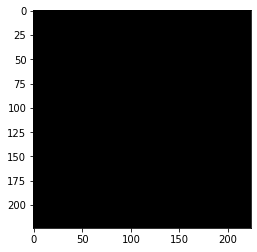

(11, 224, 224) AnnotatedCrop_0_5_2


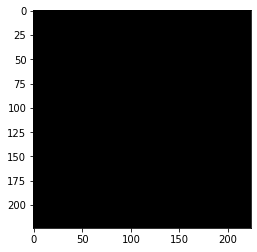

(11, 224, 224) AnnotatedCrop_0_5_3


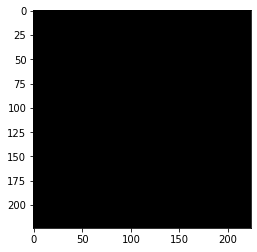

(11, 224, 224) AnnotatedCrop_0_5_4


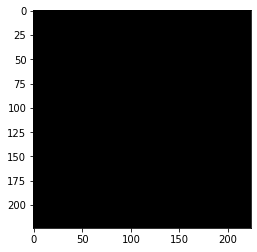

(11, 224, 224) AnnotatedCrop_0_5_5


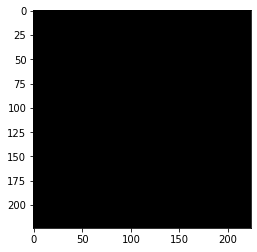

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_0_5_6


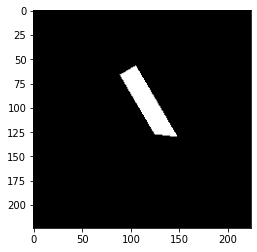

(11, 224, 224) AnnotatedCrop_0_5_7


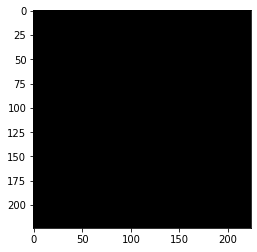

(11, 224, 224) AnnotatedCrop_0_5_8


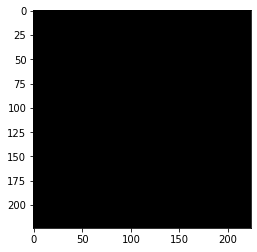

(11, 224, 224) AnnotatedCrop_0_5_9


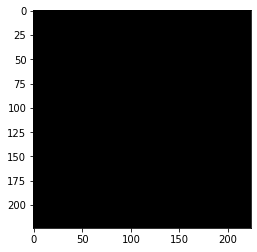

(11, 224, 224) AnnotatedCrop_0_5_10


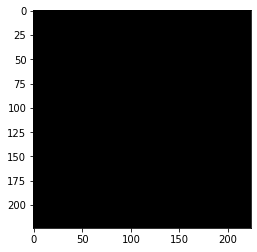

(11, 224, 224) AnnotatedCrop_0_5_11


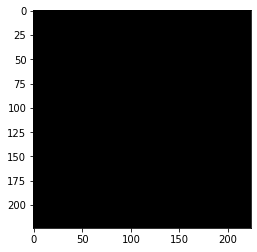

(11, 224, 192) AnnotatedCrop_0_5_12


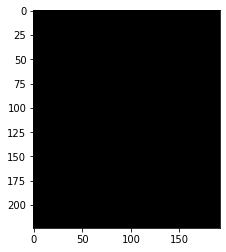

(11, 224, 224) AnnotatedCrop_0_6_0


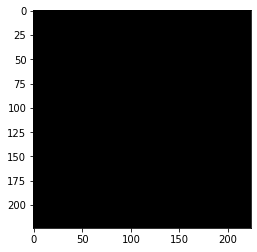

(11, 224, 224) AnnotatedCrop_0_6_1


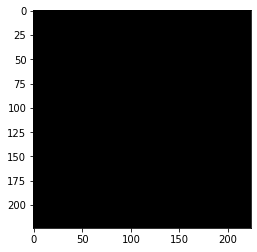

(11, 224, 224) AnnotatedCrop_0_6_2


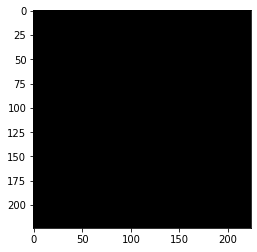

(11, 224, 224) AnnotatedCrop_0_6_3


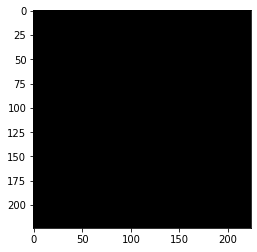

(11, 224, 224) AnnotatedCrop_0_6_4


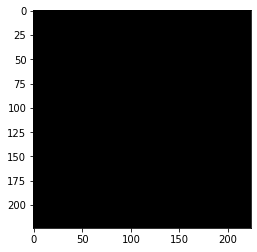

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_0_6_5


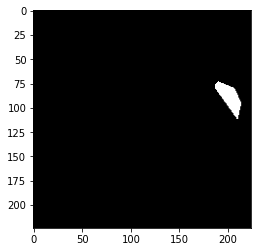

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_0_6_6


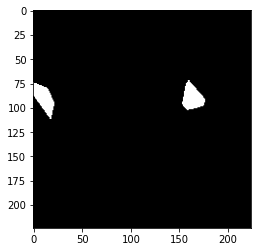

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_0_6_7


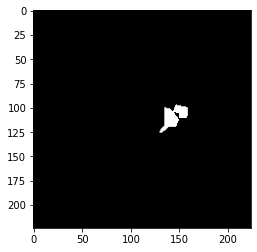

(11, 224, 224) AnnotatedCrop_0_6_8


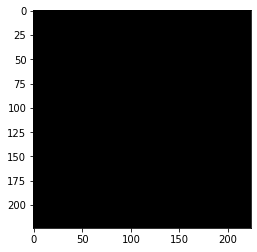

(11, 224, 224) AnnotatedCrop_0_6_9


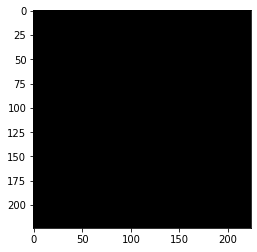

(11, 224, 224) AnnotatedCrop_0_6_10


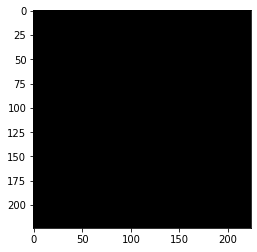

(11, 224, 224) AnnotatedCrop_0_6_11


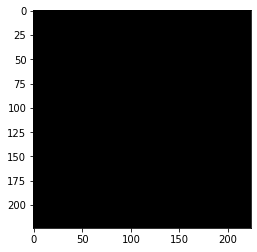

(11, 224, 192) AnnotatedCrop_0_6_12


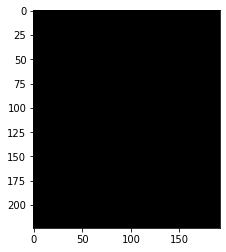

(11, 192, 224) AnnotatedCrop_0_7_0


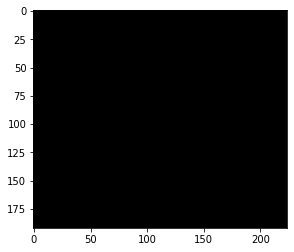

(11, 192, 224) AnnotatedCrop_0_7_1


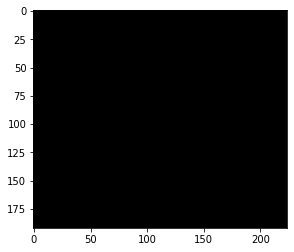

(11, 192, 224) AnnotatedCrop_0_7_2


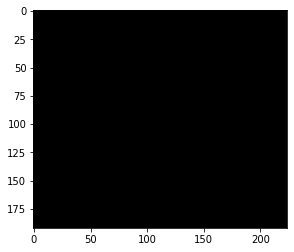

(11, 192, 224) AnnotatedCrop_0_7_3


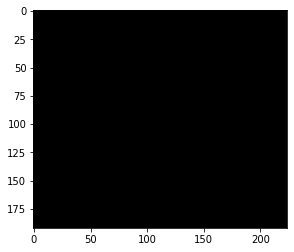

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 192, 224) AnnotatedCrop_0_7_4


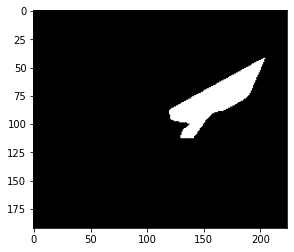

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 192, 224) AnnotatedCrop_0_7_5


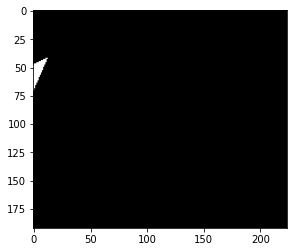

(11, 192, 224) AnnotatedCrop_0_7_6


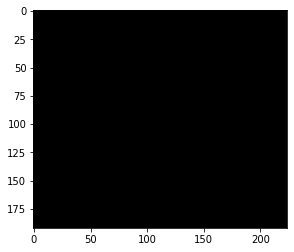

(11, 192, 224) AnnotatedCrop_0_7_7


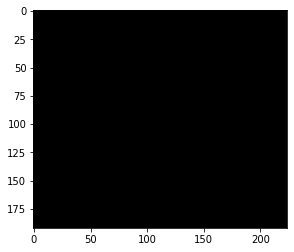

(11, 192, 224) AnnotatedCrop_0_7_8


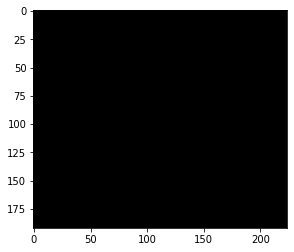

(11, 192, 224) AnnotatedCrop_0_7_9


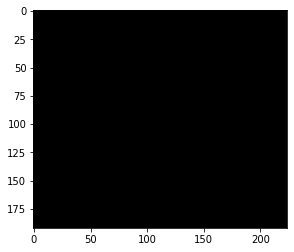

(11, 192, 224) AnnotatedCrop_0_7_10


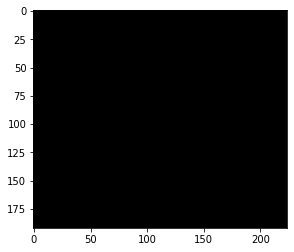

(11, 192, 224) AnnotatedCrop_0_7_11


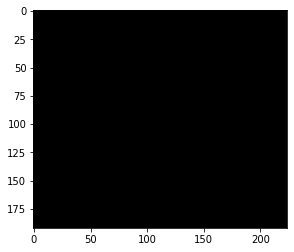

(11, 192, 192) AnnotatedCrop_0_7_12


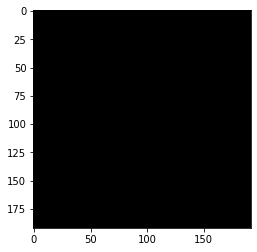

(11, 224, 224) AnnotatedCrop_1_0_0


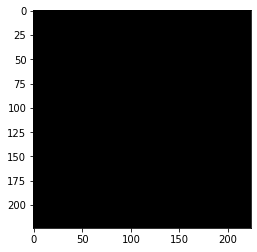

(11, 224, 224) AnnotatedCrop_1_0_1


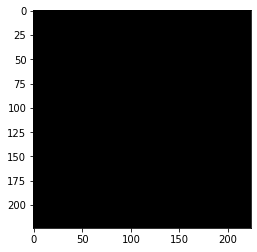

(11, 224, 224) AnnotatedCrop_1_0_2


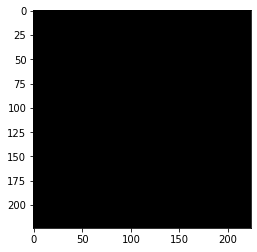

(11, 224, 224) AnnotatedCrop_1_0_3


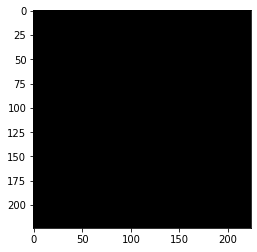

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_1_0_4


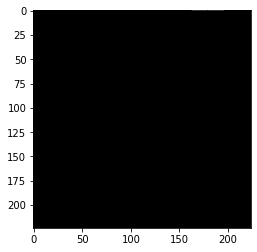

(11, 224, 224) AnnotatedCrop_1_0_5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


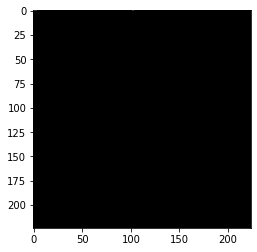

(11, 224, 224) AnnotatedCrop_1_0_6


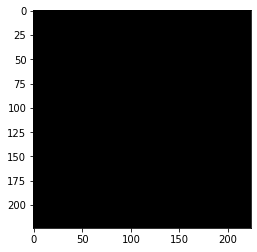

(11, 224, 224) AnnotatedCrop_1_0_7


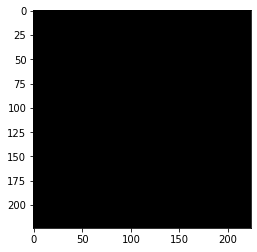

(11, 224, 224) AnnotatedCrop_1_0_8


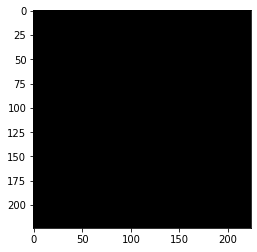

(11, 224, 224) AnnotatedCrop_1_0_9


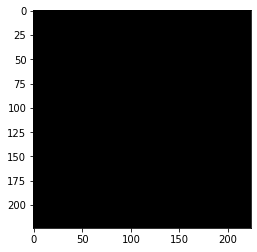

(11, 224, 224) AnnotatedCrop_1_0_10


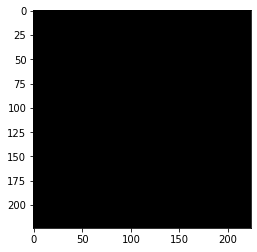

(11, 224, 224) AnnotatedCrop_1_0_11


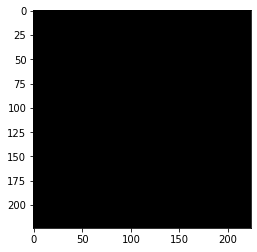

(11, 224, 192) AnnotatedCrop_1_0_12


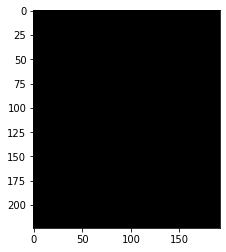

(11, 224, 224) AnnotatedCrop_1_1_0


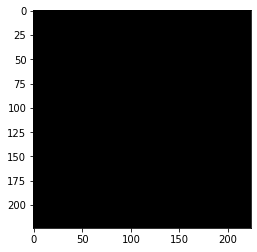

(11, 224, 224) AnnotatedCrop_1_1_1


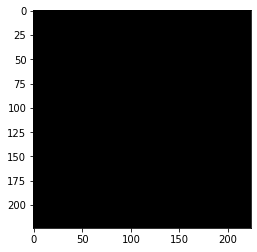

(11, 224, 224) AnnotatedCrop_1_1_2


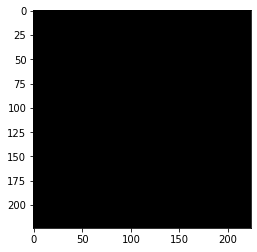

(11, 224, 224) AnnotatedCrop_1_1_3


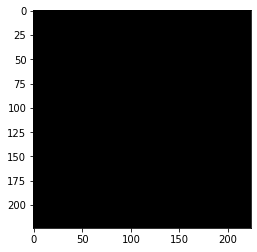

(11, 224, 224) AnnotatedCrop_1_1_4


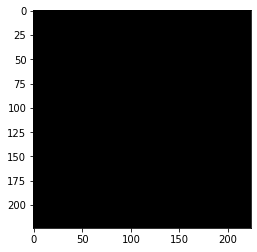

(11, 224, 224) AnnotatedCrop_1_1_5


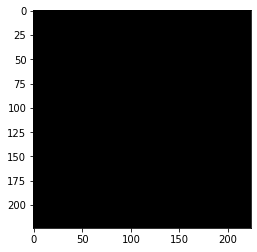

(11, 224, 224) AnnotatedCrop_1_1_6


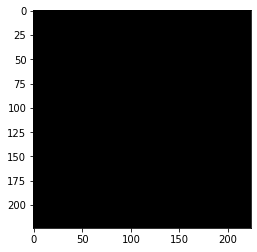

(11, 224, 224) AnnotatedCrop_1_1_7


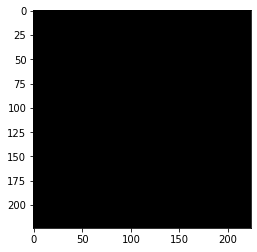

(11, 224, 224) AnnotatedCrop_1_1_8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


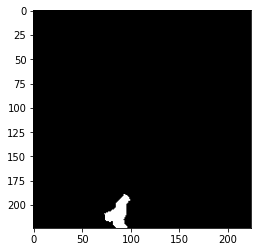

(11, 224, 224) AnnotatedCrop_1_1_9


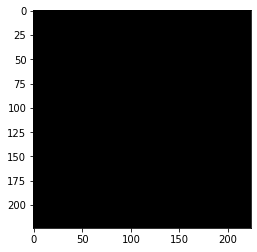

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_1_1_10


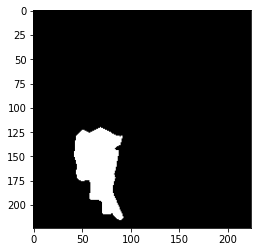

(11, 224, 224) AnnotatedCrop_1_1_11


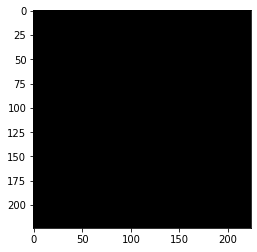

(11, 224, 192) AnnotatedCrop_1_1_12


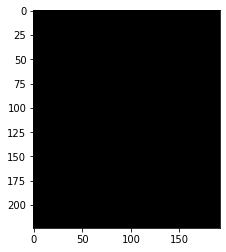

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_1_2_0


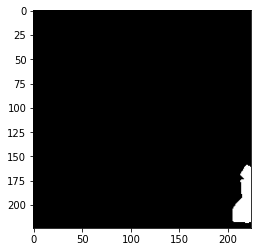

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_1_2_1


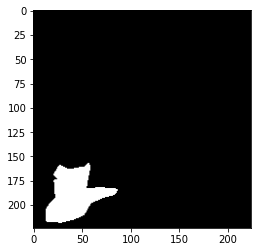

(11, 224, 224) AnnotatedCrop_1_2_2


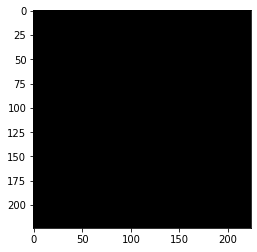

(11, 224, 224) AnnotatedCrop_1_2_3


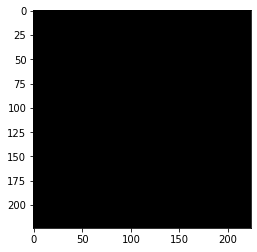

(11, 224, 224) AnnotatedCrop_1_2_4


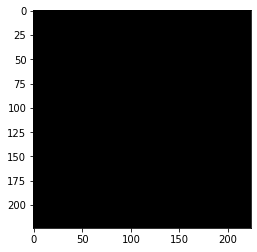

(11, 224, 224) AnnotatedCrop_1_2_5


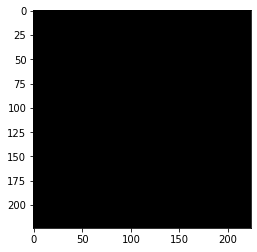

(11, 224, 224) AnnotatedCrop_1_2_6


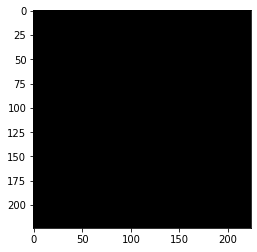

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_1_2_7


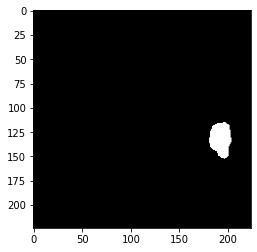

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_1_2_8


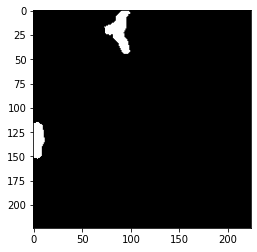

(11, 224, 224) AnnotatedCrop_1_2_9


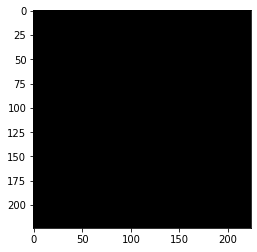

(11, 224, 224) AnnotatedCrop_1_2_10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


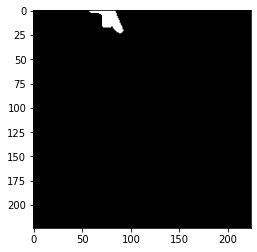

(11, 224, 224) AnnotatedCrop_1_2_11


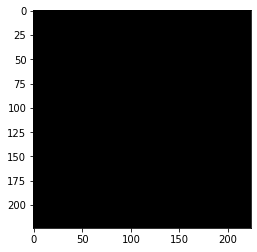

(11, 224, 192) AnnotatedCrop_1_2_12


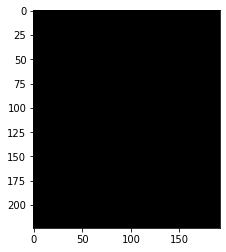

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_1_3_0


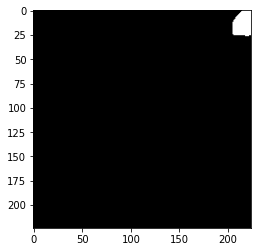

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_1_3_1


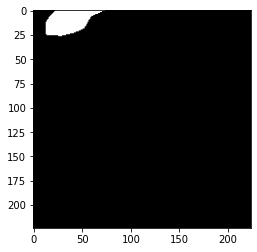

(11, 224, 224) AnnotatedCrop_1_3_2


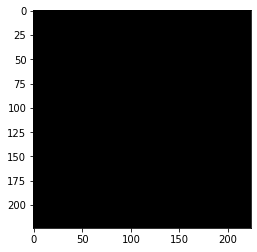

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_1_3_3


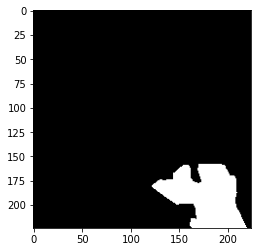

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_1_3_4


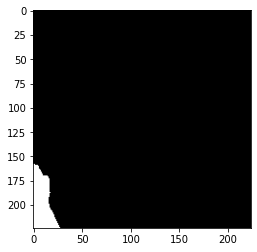

(11, 224, 224) AnnotatedCrop_1_3_5


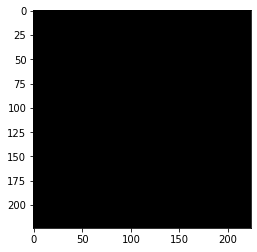

(11, 224, 224) AnnotatedCrop_1_3_6


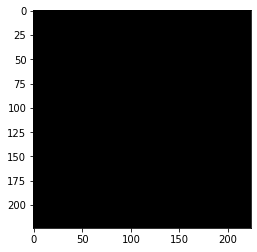

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_1_3_7


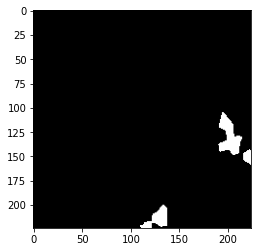

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_1_3_8


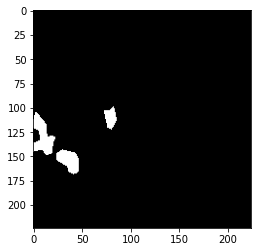

(11, 224, 224) AnnotatedCrop_1_3_9


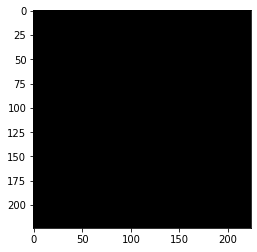

(11, 224, 224) AnnotatedCrop_1_3_10


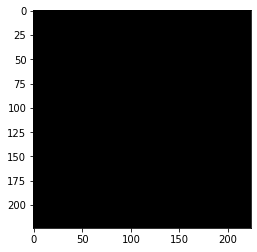

(11, 224, 224) AnnotatedCrop_1_3_11


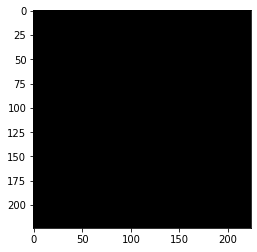

(11, 224, 192) AnnotatedCrop_1_3_12


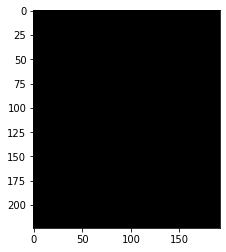

(11, 224, 224) AnnotatedCrop_1_4_0


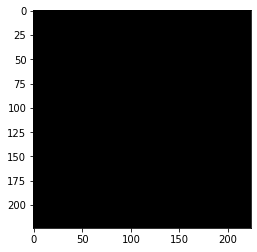

(11, 224, 224) AnnotatedCrop_1_4_1


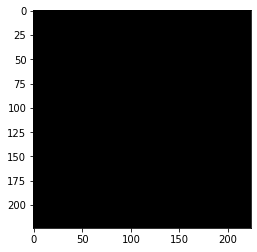

(11, 224, 224) AnnotatedCrop_1_4_2


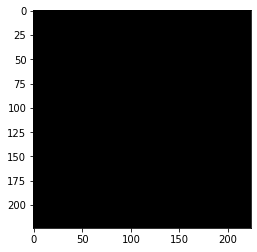

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_1_4_3


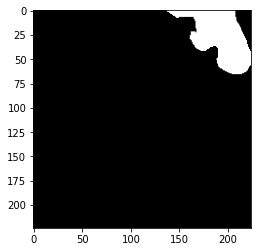

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_1_4_4


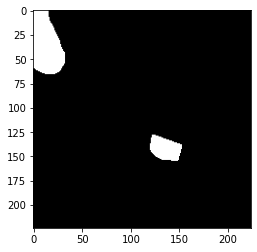

(11, 224, 224) AnnotatedCrop_1_4_5


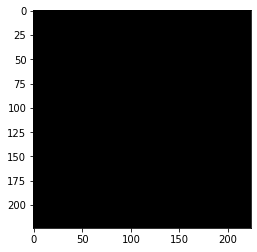

(11, 224, 224) AnnotatedCrop_1_4_6


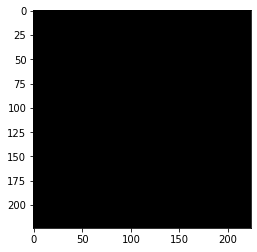

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_1_4_7


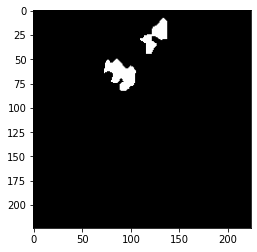

(11, 224, 224) AnnotatedCrop_1_4_8


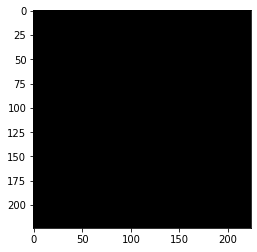

(11, 224, 224) AnnotatedCrop_1_4_9


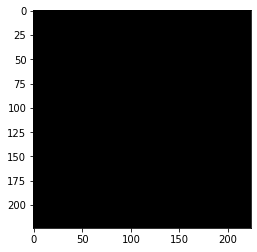

(11, 224, 224) AnnotatedCrop_1_4_10


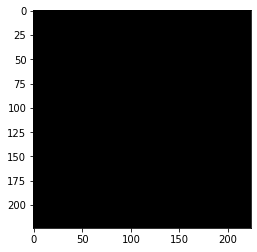

(11, 224, 224) AnnotatedCrop_1_4_11


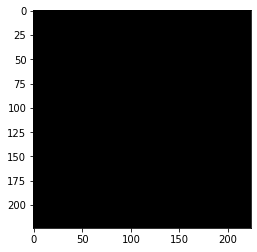

(11, 224, 192) AnnotatedCrop_1_4_12


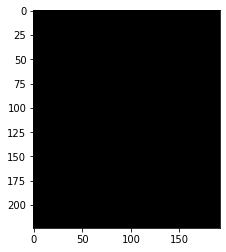

(11, 224, 224) AnnotatedCrop_1_5_0


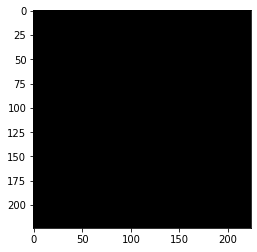

(11, 224, 224) AnnotatedCrop_1_5_1


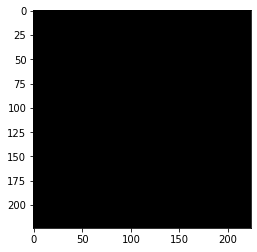

(11, 224, 224) AnnotatedCrop_1_5_2


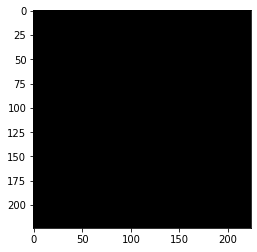

(11, 224, 224) AnnotatedCrop_1_5_3


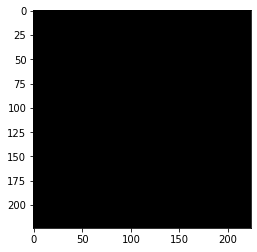

(11, 224, 224) AnnotatedCrop_1_5_4


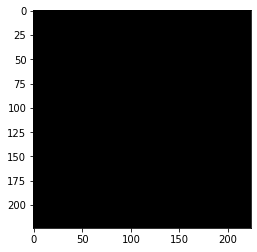

(11, 224, 224) AnnotatedCrop_1_5_5


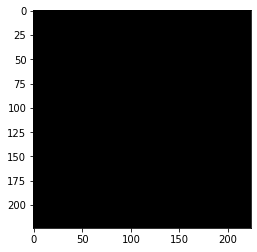

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_1_5_6


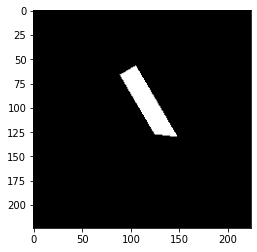

(11, 224, 224) AnnotatedCrop_1_5_7


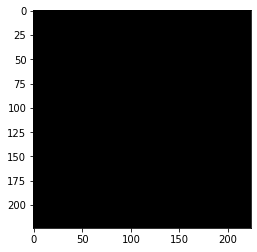

(11, 224, 224) AnnotatedCrop_1_5_8


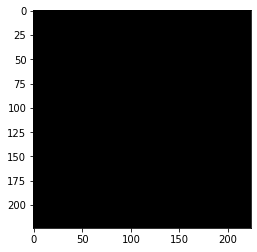

(11, 224, 224) AnnotatedCrop_1_5_9


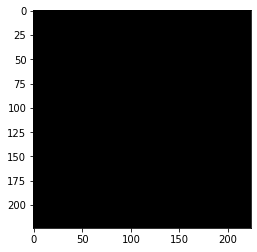

(11, 224, 224) AnnotatedCrop_1_5_10


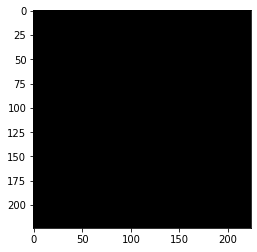

(11, 224, 224) AnnotatedCrop_1_5_11


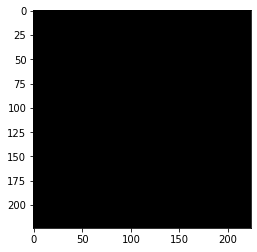

(11, 224, 192) AnnotatedCrop_1_5_12


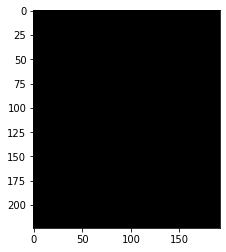

(11, 224, 224) AnnotatedCrop_1_6_0


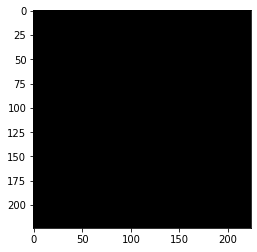

(11, 224, 224) AnnotatedCrop_1_6_1


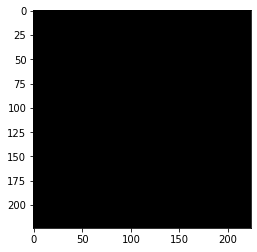

(11, 224, 224) AnnotatedCrop_1_6_2


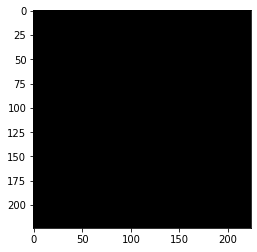

(11, 224, 224) AnnotatedCrop_1_6_3


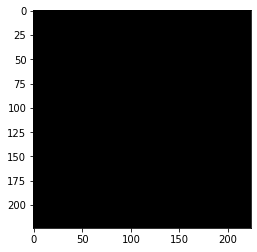

(11, 224, 224) AnnotatedCrop_1_6_4


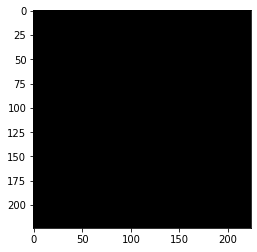

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_1_6_5


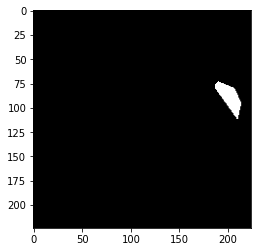

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_1_6_6


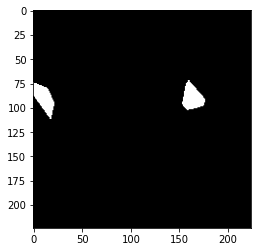

(11, 224, 224) AnnotatedCrop_1_6_7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


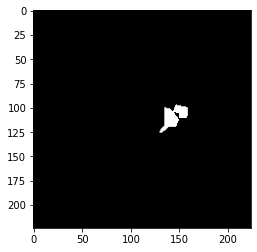

(11, 224, 224) AnnotatedCrop_1_6_8


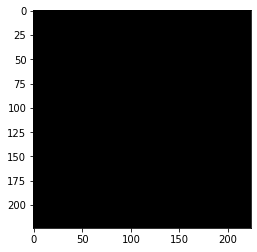

(11, 224, 224) AnnotatedCrop_1_6_9


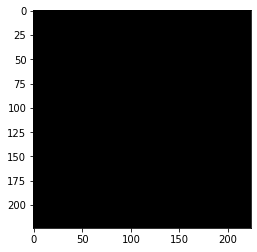

(11, 224, 224) AnnotatedCrop_1_6_10


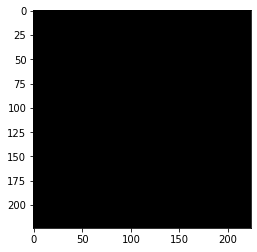

(11, 224, 224) AnnotatedCrop_1_6_11


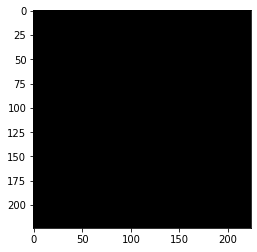

(11, 224, 192) AnnotatedCrop_1_6_12


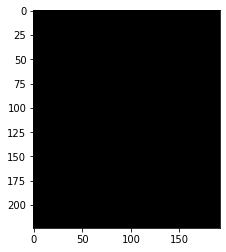

(11, 192, 224) AnnotatedCrop_1_7_0


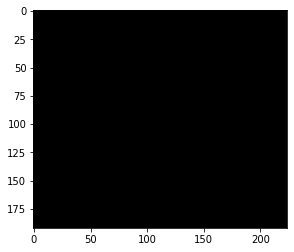

(11, 192, 224) AnnotatedCrop_1_7_1


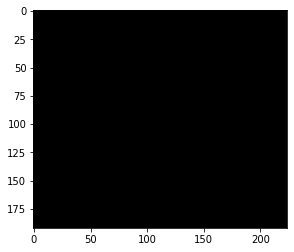

(11, 192, 224) AnnotatedCrop_1_7_2


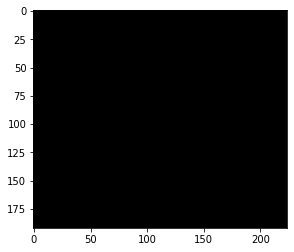

(11, 192, 224) AnnotatedCrop_1_7_3


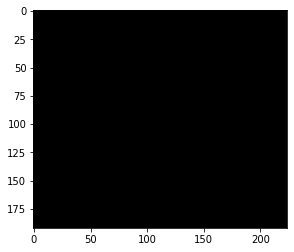

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 192, 224) AnnotatedCrop_1_7_4


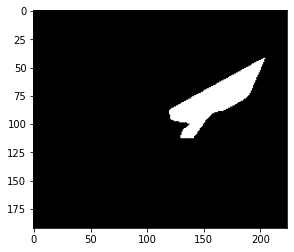

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 192, 224) AnnotatedCrop_1_7_5


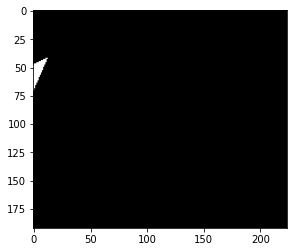

(11, 192, 224) AnnotatedCrop_1_7_6


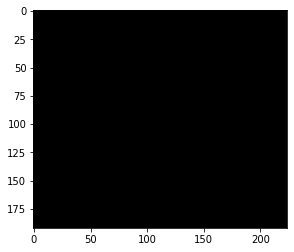

(11, 192, 224) AnnotatedCrop_1_7_7


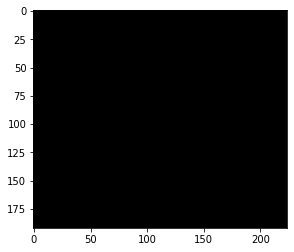

(11, 192, 224) AnnotatedCrop_1_7_8


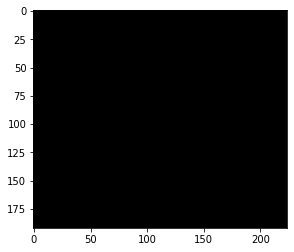

(11, 192, 224) AnnotatedCrop_1_7_9


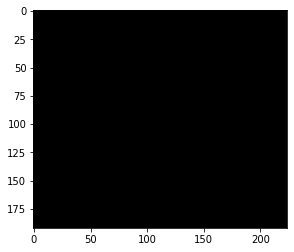

(11, 192, 224) AnnotatedCrop_1_7_10


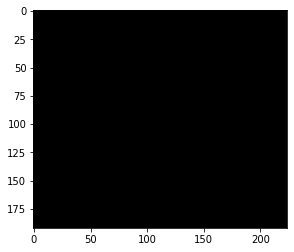

(11, 192, 224) AnnotatedCrop_1_7_11


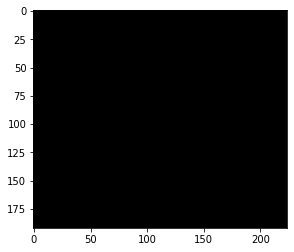

(11, 192, 192) AnnotatedCrop_1_7_12


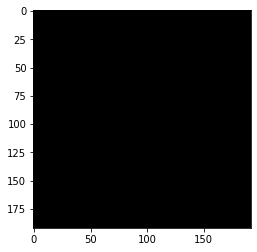

(11, 224, 224) AnnotatedCrop_2_0_0


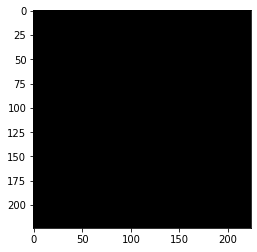

(11, 224, 224) AnnotatedCrop_2_0_1


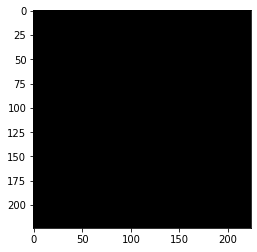

(11, 224, 224) AnnotatedCrop_2_0_2


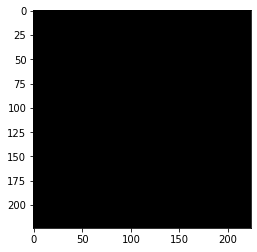

(11, 224, 224) AnnotatedCrop_2_0_3


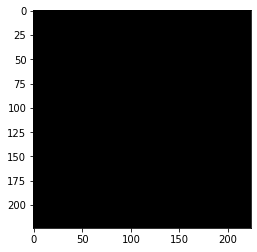

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_2_0_4


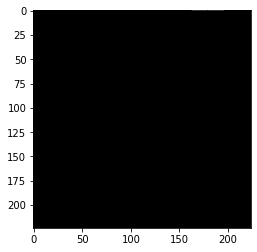

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_2_0_5


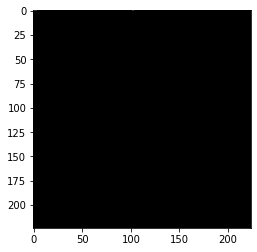

(11, 224, 224) AnnotatedCrop_2_0_6


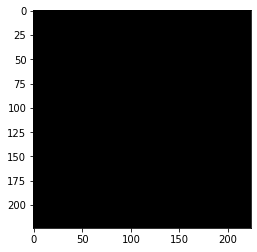

(11, 224, 224) AnnotatedCrop_2_0_7


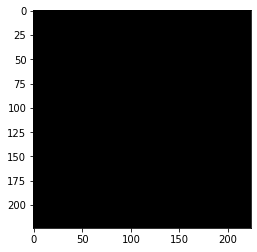

(11, 224, 224) AnnotatedCrop_2_0_8


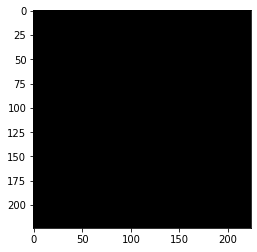

(11, 224, 224) AnnotatedCrop_2_0_9


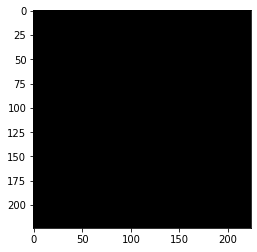

(11, 224, 224) AnnotatedCrop_2_0_10


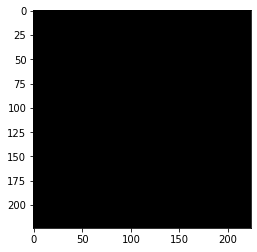

(11, 224, 224) AnnotatedCrop_2_0_11


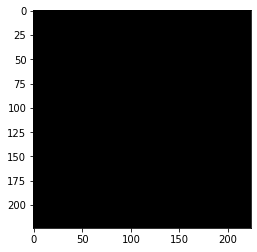

(11, 224, 192) AnnotatedCrop_2_0_12


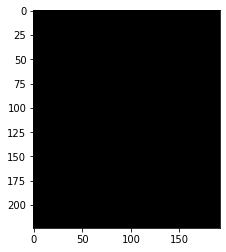

(11, 224, 224) AnnotatedCrop_2_1_0


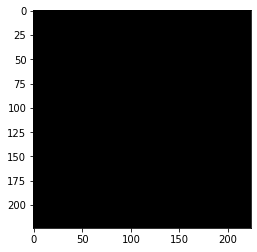

(11, 224, 224) AnnotatedCrop_2_1_1


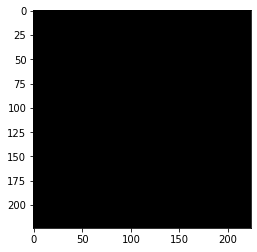

(11, 224, 224) AnnotatedCrop_2_1_2


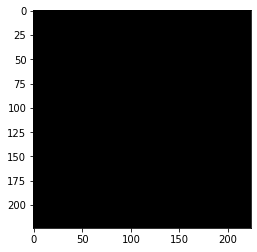

(11, 224, 224) AnnotatedCrop_2_1_3


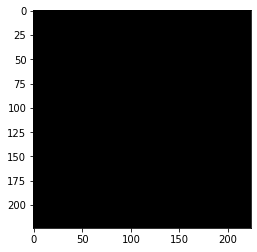

(11, 224, 224) AnnotatedCrop_2_1_4


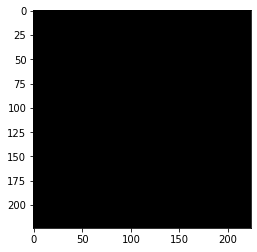

(11, 224, 224) AnnotatedCrop_2_1_5


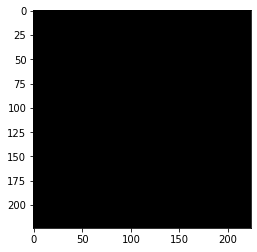

(11, 224, 224) AnnotatedCrop_2_1_6


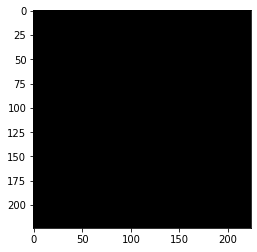

(11, 224, 224) AnnotatedCrop_2_1_7


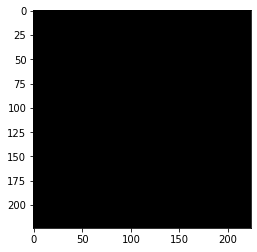

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_2_1_8


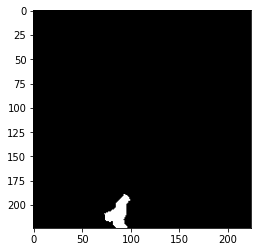

(11, 224, 224) AnnotatedCrop_2_1_9


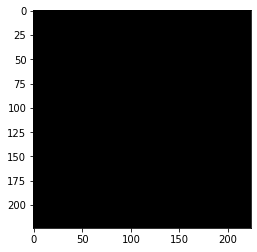

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_2_1_10


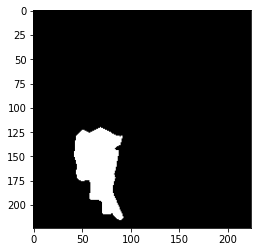

(11, 224, 224) AnnotatedCrop_2_1_11


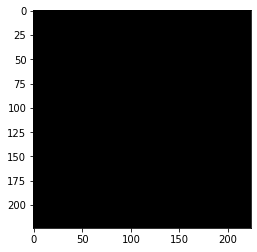

(11, 224, 192) AnnotatedCrop_2_1_12


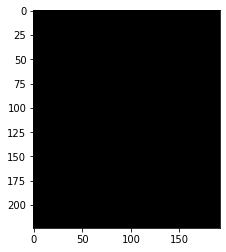

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_2_2_0


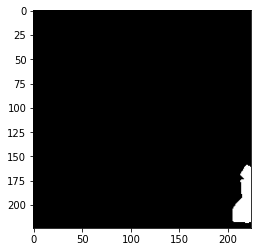

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_2_2_1


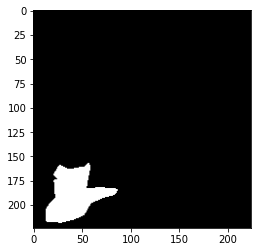

(11, 224, 224) AnnotatedCrop_2_2_2


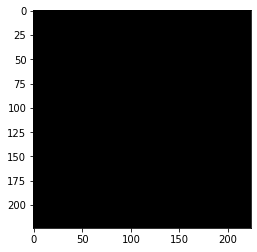

(11, 224, 224) AnnotatedCrop_2_2_3


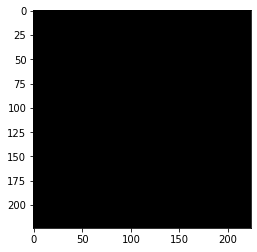

(11, 224, 224) AnnotatedCrop_2_2_4


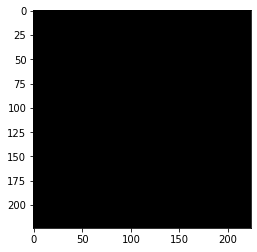

(11, 224, 224) AnnotatedCrop_2_2_5


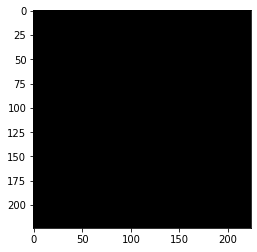

(11, 224, 224) AnnotatedCrop_2_2_6


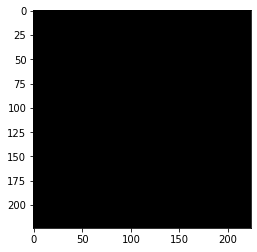

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_2_2_7


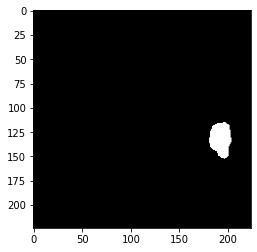

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_2_2_8


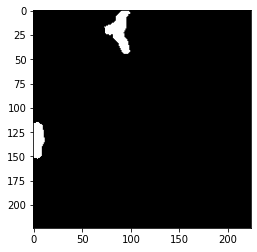

(11, 224, 224) AnnotatedCrop_2_2_9


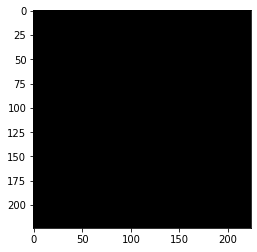

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_2_2_10


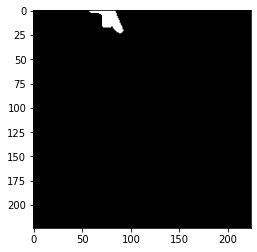

(11, 224, 224) AnnotatedCrop_2_2_11


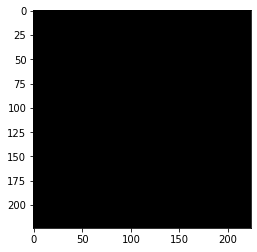

(11, 224, 192) AnnotatedCrop_2_2_12


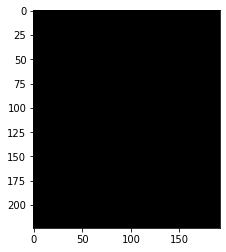

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_2_3_0


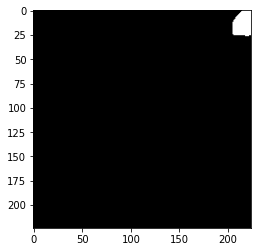

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_2_3_1


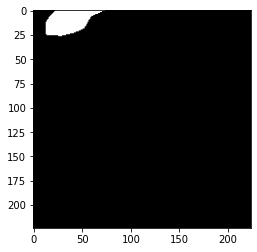

(11, 224, 224) AnnotatedCrop_2_3_2


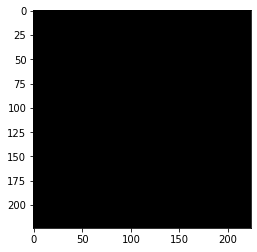

(11, 224, 224) AnnotatedCrop_2_3_3


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


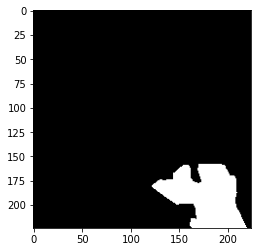

(11, 224, 224) AnnotatedCrop_2_3_4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


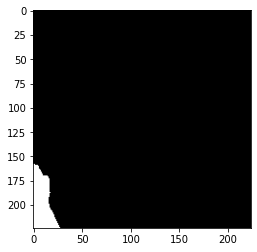

(11, 224, 224) AnnotatedCrop_2_3_5


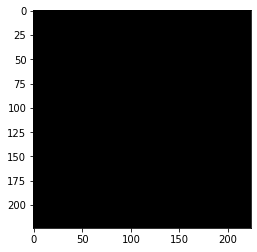

(11, 224, 224) AnnotatedCrop_2_3_6


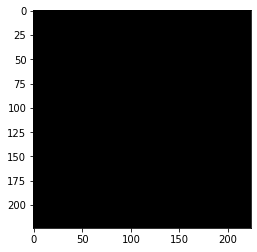

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_2_3_7


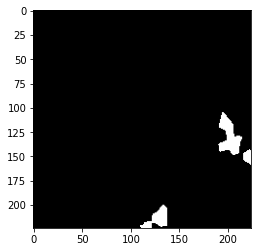

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_2_3_8


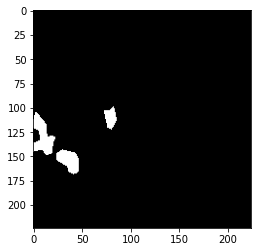

(11, 224, 224) AnnotatedCrop_2_3_9


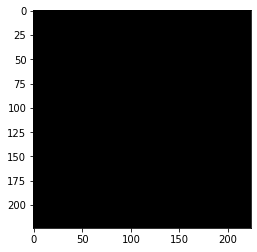

(11, 224, 224) AnnotatedCrop_2_3_10


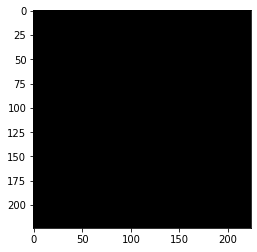

(11, 224, 224) AnnotatedCrop_2_3_11


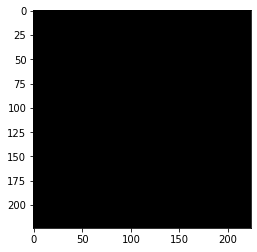

(11, 224, 192) AnnotatedCrop_2_3_12


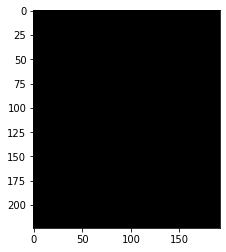

(11, 224, 224) AnnotatedCrop_2_4_0


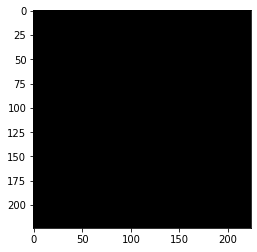

(11, 224, 224) AnnotatedCrop_2_4_1


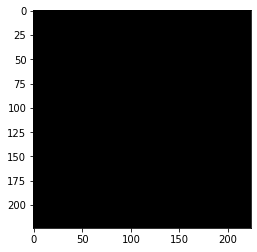

(11, 224, 224) AnnotatedCrop_2_4_2


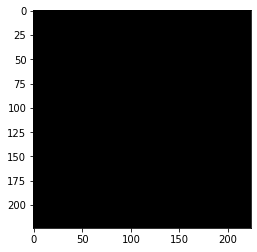

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_2_4_3


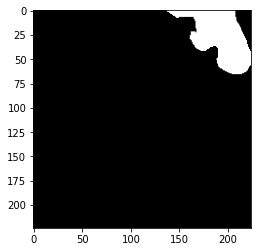

(11, 224, 224) AnnotatedCrop_2_4_4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


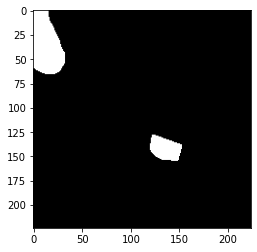

(11, 224, 224) AnnotatedCrop_2_4_5


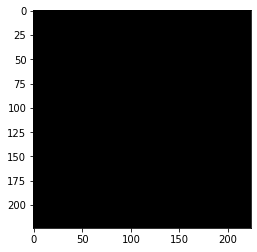

(11, 224, 224) AnnotatedCrop_2_4_6


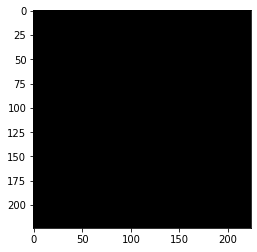

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_2_4_7


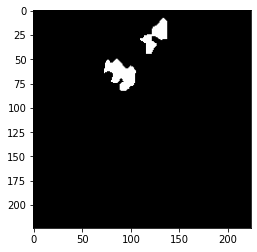

(11, 224, 224) AnnotatedCrop_2_4_8


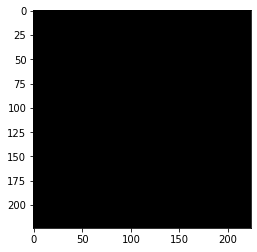

(11, 224, 224) AnnotatedCrop_2_4_9


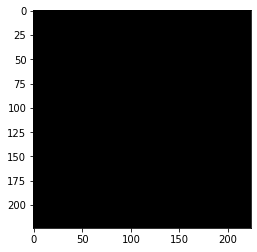

(11, 224, 224) AnnotatedCrop_2_4_10


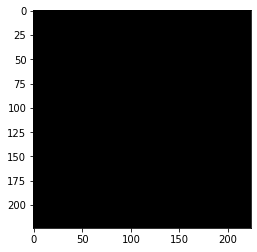

(11, 224, 224) AnnotatedCrop_2_4_11


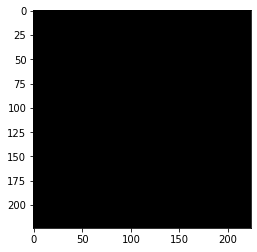

(11, 224, 192) AnnotatedCrop_2_4_12


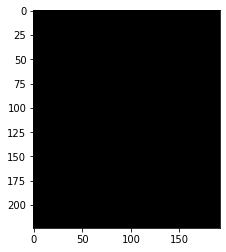

(11, 224, 224) AnnotatedCrop_2_5_0


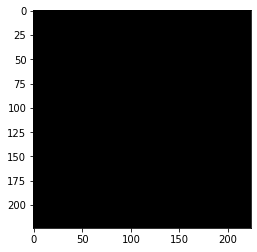

(11, 224, 224) AnnotatedCrop_2_5_1


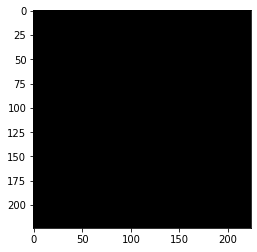

(11, 224, 224) AnnotatedCrop_2_5_2


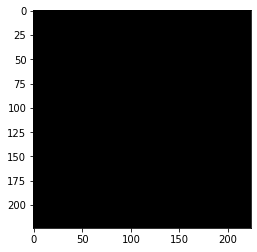

(11, 224, 224) AnnotatedCrop_2_5_3


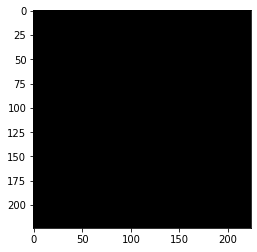

(11, 224, 224) AnnotatedCrop_2_5_4


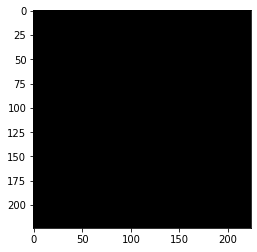

(11, 224, 224) AnnotatedCrop_2_5_5


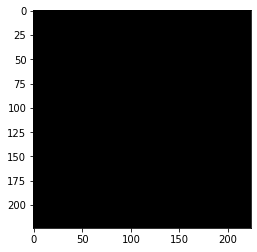

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_2_5_6


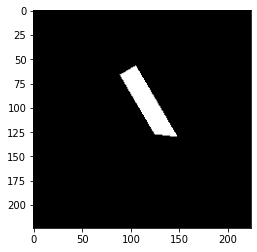

(11, 224, 224) AnnotatedCrop_2_5_7


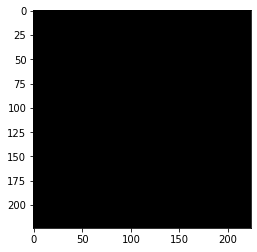

(11, 224, 224) AnnotatedCrop_2_5_8


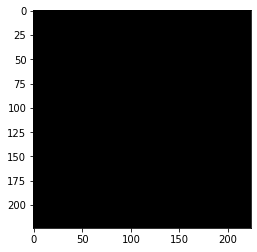

(11, 224, 224) AnnotatedCrop_2_5_9


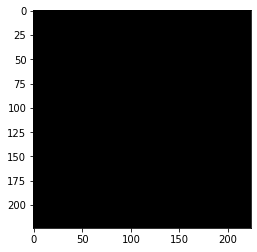

(11, 224, 224) AnnotatedCrop_2_5_10


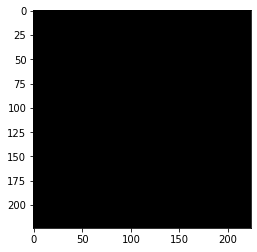

(11, 224, 224) AnnotatedCrop_2_5_11


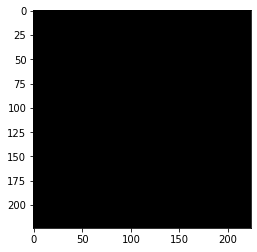

(11, 224, 192) AnnotatedCrop_2_5_12


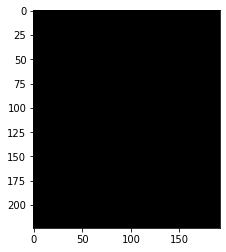

(11, 224, 224) AnnotatedCrop_2_6_0


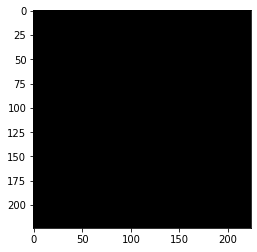

(11, 224, 224) AnnotatedCrop_2_6_1


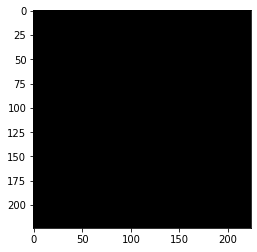

(11, 224, 224) AnnotatedCrop_2_6_2


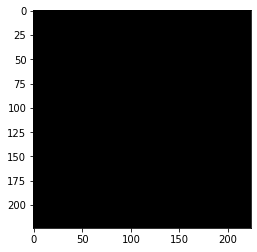

(11, 224, 224) AnnotatedCrop_2_6_3


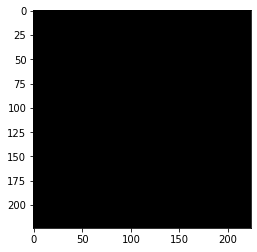

(11, 224, 224) AnnotatedCrop_2_6_4


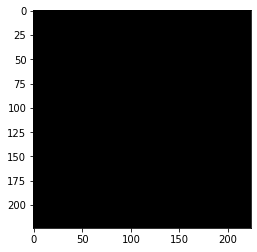

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_2_6_5


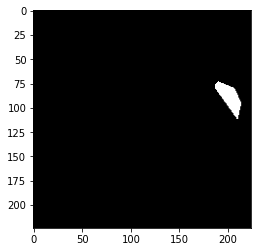

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_2_6_6


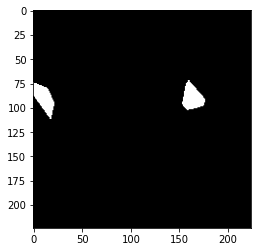

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_2_6_7


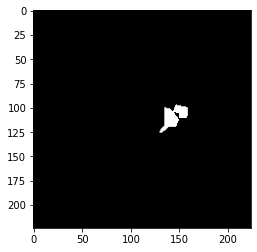

(11, 224, 224) AnnotatedCrop_2_6_8


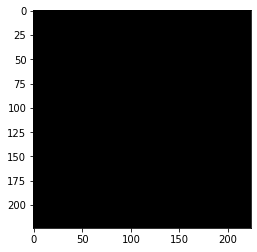

(11, 224, 224) AnnotatedCrop_2_6_9


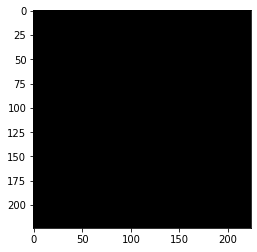

(11, 224, 224) AnnotatedCrop_2_6_10


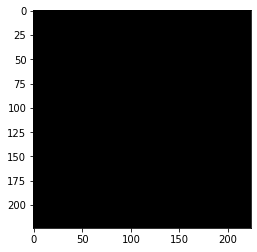

(11, 224, 224) AnnotatedCrop_2_6_11


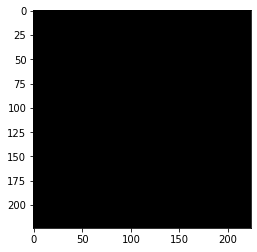

(11, 224, 192) AnnotatedCrop_2_6_12


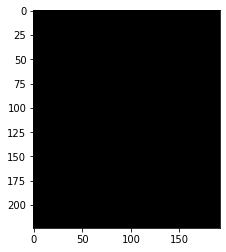

(11, 192, 224) AnnotatedCrop_2_7_0


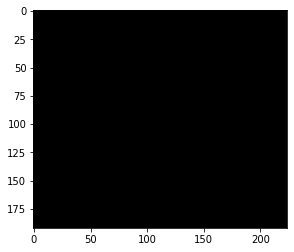

(11, 192, 224) AnnotatedCrop_2_7_1


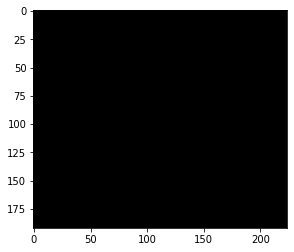

(11, 192, 224) AnnotatedCrop_2_7_2


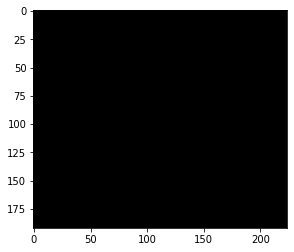

(11, 192, 224) AnnotatedCrop_2_7_3


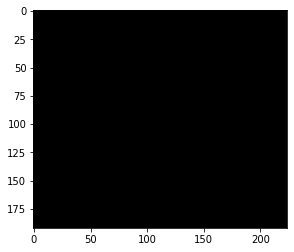

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 192, 224) AnnotatedCrop_2_7_4


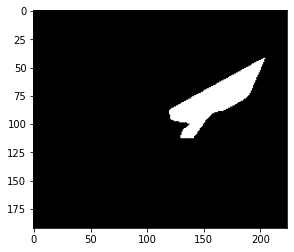

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 192, 224) AnnotatedCrop_2_7_5


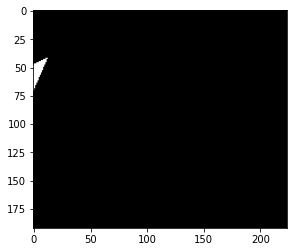

(11, 192, 224) AnnotatedCrop_2_7_6


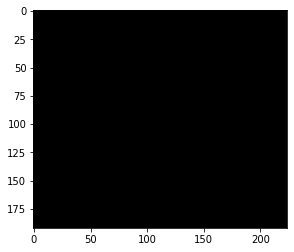

(11, 192, 224) AnnotatedCrop_2_7_7


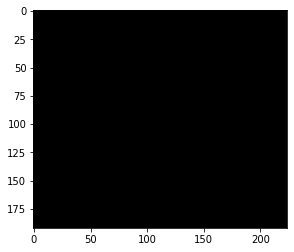

(11, 192, 224) AnnotatedCrop_2_7_8


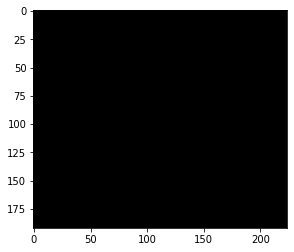

(11, 192, 224) AnnotatedCrop_2_7_9


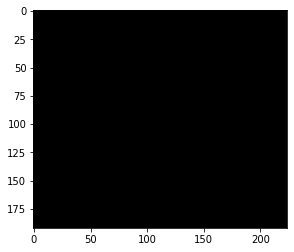

(11, 192, 224) AnnotatedCrop_2_7_10


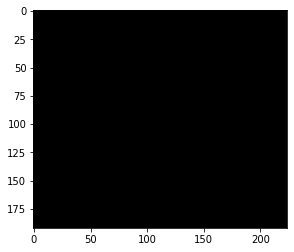

(11, 192, 224) AnnotatedCrop_2_7_11


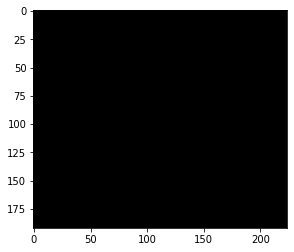

(11, 192, 192) AnnotatedCrop_2_7_12


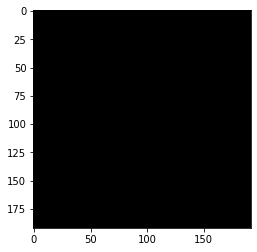

(11, 224, 224) AnnotatedCrop_3_0_0


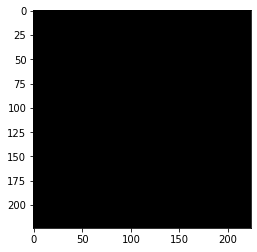

(11, 224, 224) AnnotatedCrop_3_0_1


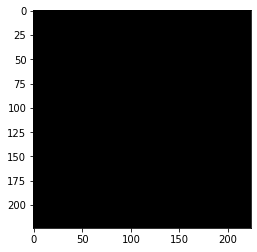

(11, 224, 224) AnnotatedCrop_3_0_2


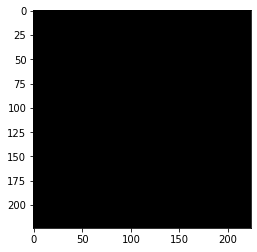

(11, 224, 224) AnnotatedCrop_3_0_3


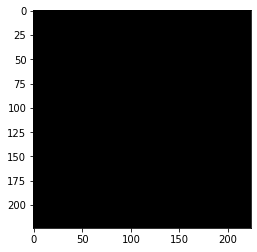

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_3_0_4


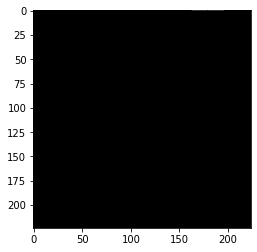

(11, 224, 224) AnnotatedCrop_3_0_5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


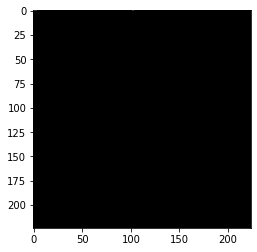

(11, 224, 224) AnnotatedCrop_3_0_6


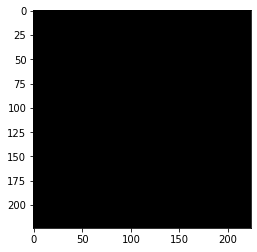

(11, 224, 224) AnnotatedCrop_3_0_7


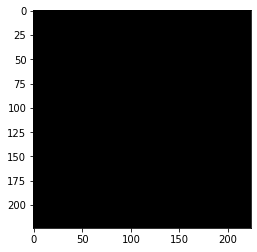

(11, 224, 224) AnnotatedCrop_3_0_8


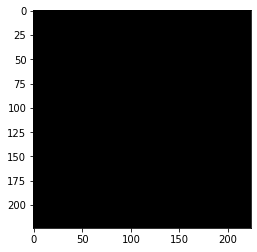

(11, 224, 224) AnnotatedCrop_3_0_9


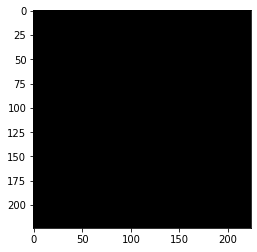

(11, 224, 224) AnnotatedCrop_3_0_10


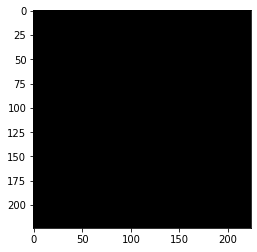

(11, 224, 224) AnnotatedCrop_3_0_11


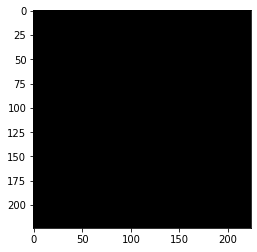

(11, 224, 192) AnnotatedCrop_3_0_12


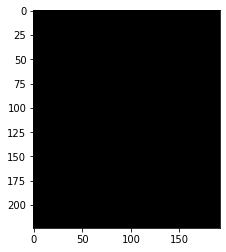

(11, 224, 224) AnnotatedCrop_3_1_0


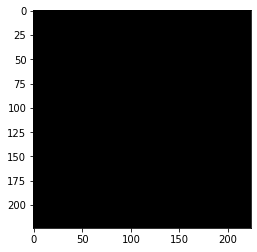

(11, 224, 224) AnnotatedCrop_3_1_1


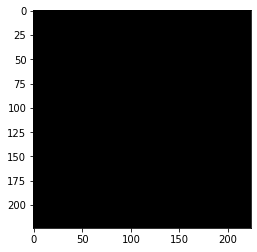

(11, 224, 224) AnnotatedCrop_3_1_2


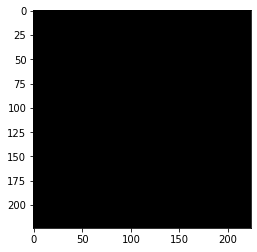

(11, 224, 224) AnnotatedCrop_3_1_3


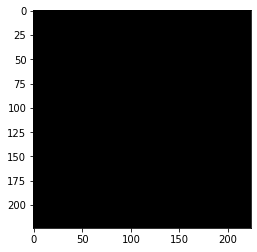

(11, 224, 224) AnnotatedCrop_3_1_4


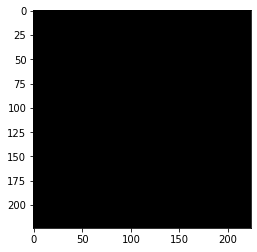

(11, 224, 224) AnnotatedCrop_3_1_5


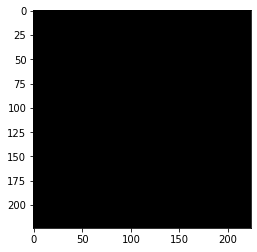

(11, 224, 224) AnnotatedCrop_3_1_6


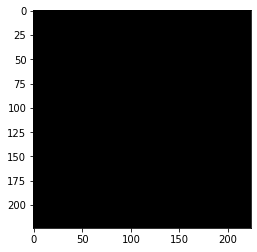

(11, 224, 224) AnnotatedCrop_3_1_7


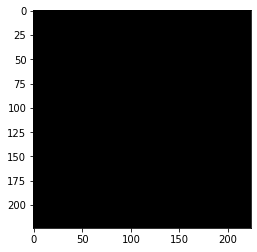

(11, 224, 224) AnnotatedCrop_3_1_8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


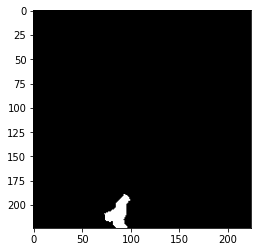

(11, 224, 224) AnnotatedCrop_3_1_9


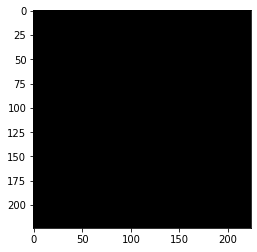

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_3_1_10


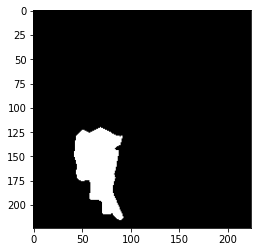

(11, 224, 224) AnnotatedCrop_3_1_11


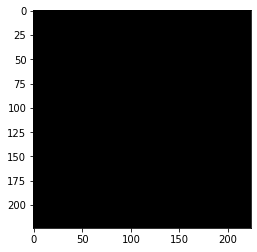

(11, 224, 192) AnnotatedCrop_3_1_12


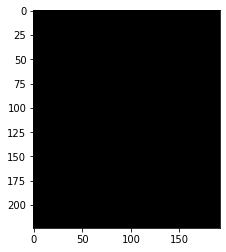

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_3_2_0


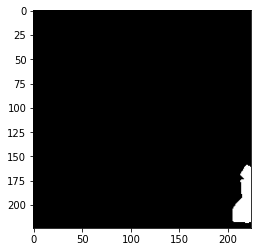

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_3_2_1


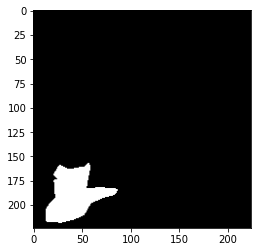

(11, 224, 224) AnnotatedCrop_3_2_2


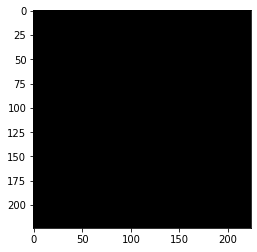

(11, 224, 224) AnnotatedCrop_3_2_3


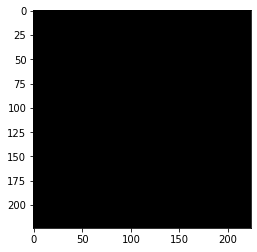

(11, 224, 224) AnnotatedCrop_3_2_4


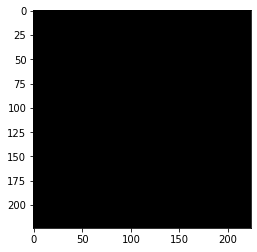

(11, 224, 224) AnnotatedCrop_3_2_5


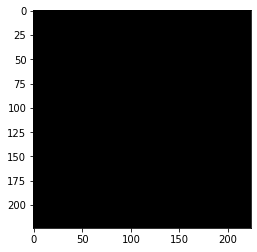

(11, 224, 224) AnnotatedCrop_3_2_6


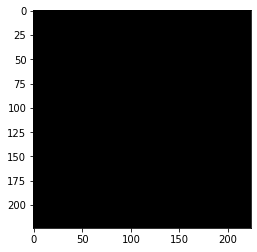

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_3_2_7


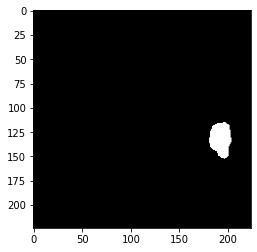

(11, 224, 224) AnnotatedCrop_3_2_8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


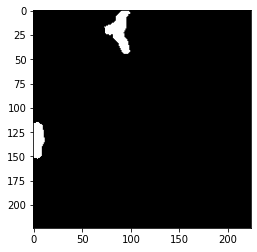

(11, 224, 224) AnnotatedCrop_3_2_9


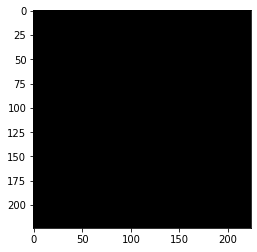

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_3_2_10


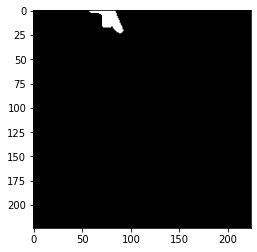

(11, 224, 224) AnnotatedCrop_3_2_11


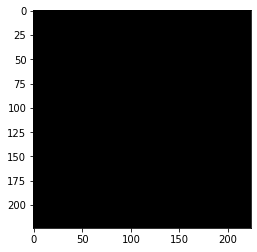

(11, 224, 192) AnnotatedCrop_3_2_12


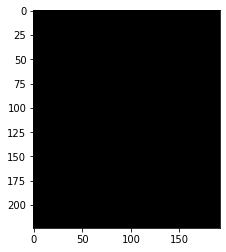

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_3_3_0


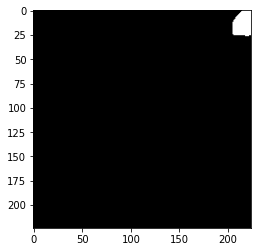

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_3_3_1


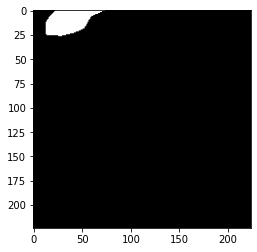

(11, 224, 224) AnnotatedCrop_3_3_2


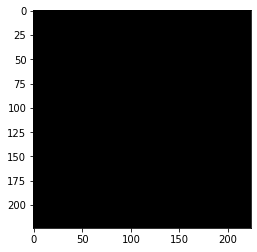

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_3_3_3


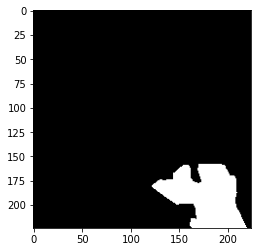

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_3_3_4


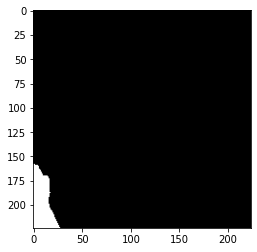

(11, 224, 224) AnnotatedCrop_3_3_5


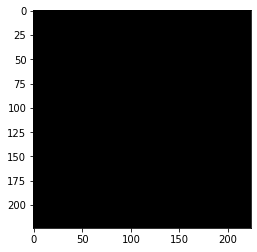

(11, 224, 224) AnnotatedCrop_3_3_6


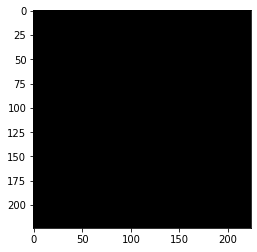

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_3_3_7


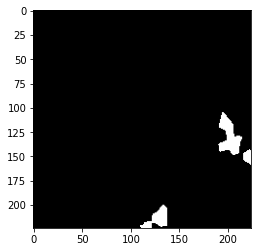

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_3_3_8


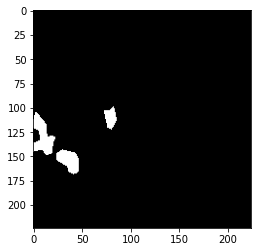

(11, 224, 224) AnnotatedCrop_3_3_9


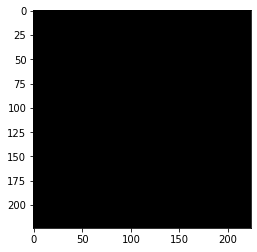

(11, 224, 224) AnnotatedCrop_3_3_10


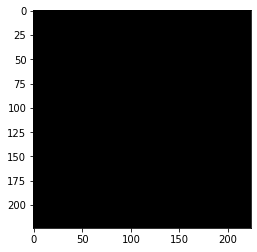

(11, 224, 224) AnnotatedCrop_3_3_11


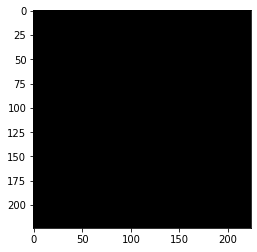

(11, 224, 192) AnnotatedCrop_3_3_12


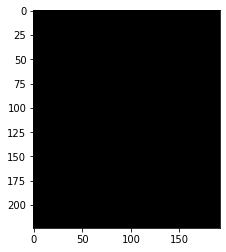

(11, 224, 224) AnnotatedCrop_3_4_0


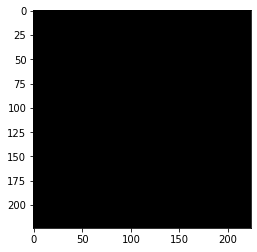

(11, 224, 224) AnnotatedCrop_3_4_1


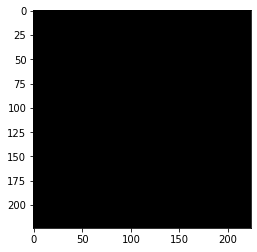

(11, 224, 224) AnnotatedCrop_3_4_2


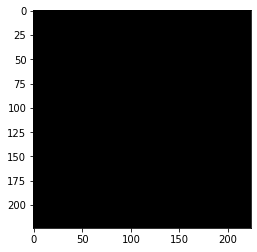

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_3_4_3


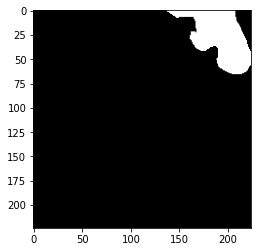

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_3_4_4


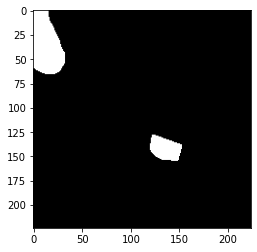

(11, 224, 224) AnnotatedCrop_3_4_5


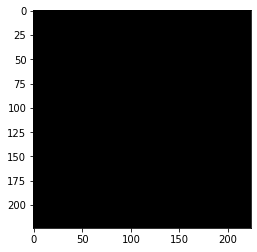

(11, 224, 224) AnnotatedCrop_3_4_6


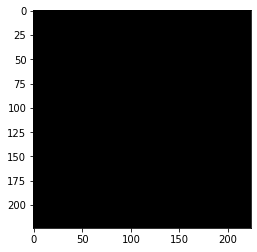

(11, 224, 224) AnnotatedCrop_3_4_7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


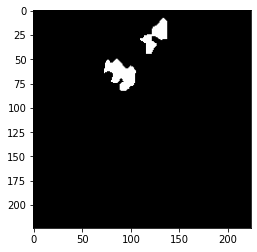

(11, 224, 224) AnnotatedCrop_3_4_8


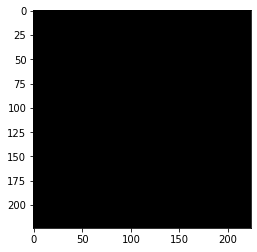

(11, 224, 224) AnnotatedCrop_3_4_9


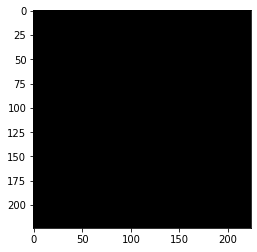

(11, 224, 224) AnnotatedCrop_3_4_10


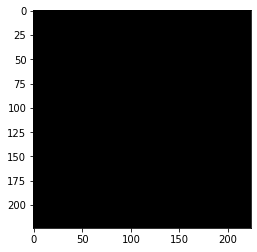

(11, 224, 224) AnnotatedCrop_3_4_11


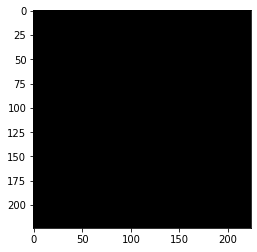

(11, 224, 192) AnnotatedCrop_3_4_12


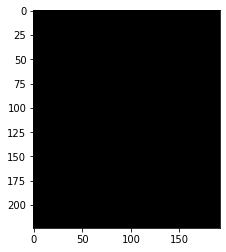

(11, 224, 224) AnnotatedCrop_3_5_0


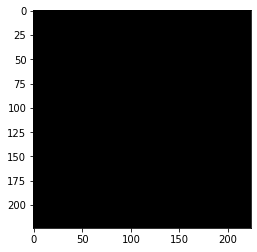

(11, 224, 224) AnnotatedCrop_3_5_1


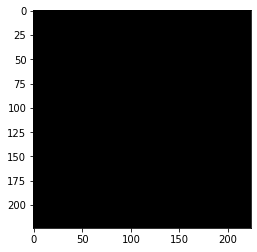

(11, 224, 224) AnnotatedCrop_3_5_2


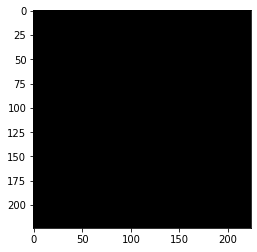

(11, 224, 224) AnnotatedCrop_3_5_3


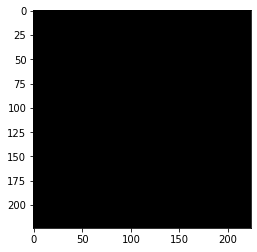

(11, 224, 224) AnnotatedCrop_3_5_4


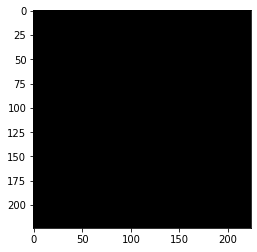

(11, 224, 224) AnnotatedCrop_3_5_5


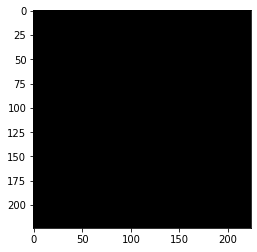

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_3_5_6


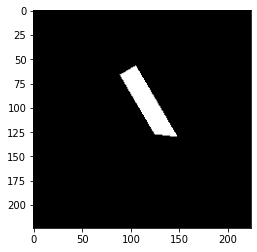

(11, 224, 224) AnnotatedCrop_3_5_7


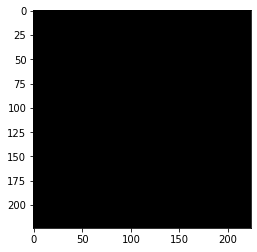

(11, 224, 224) AnnotatedCrop_3_5_8


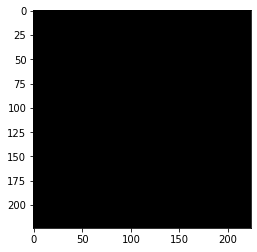

(11, 224, 224) AnnotatedCrop_3_5_9


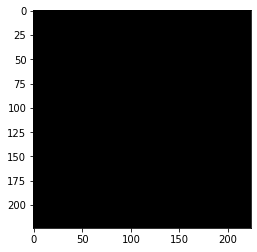

(11, 224, 224) AnnotatedCrop_3_5_10


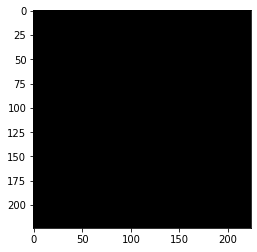

(11, 224, 224) AnnotatedCrop_3_5_11


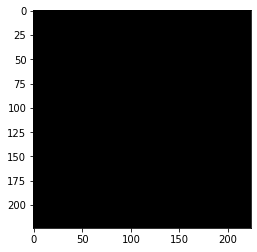

(11, 224, 192) AnnotatedCrop_3_5_12


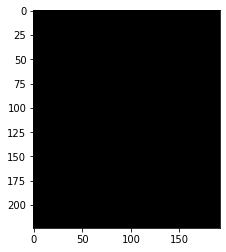

(11, 224, 224) AnnotatedCrop_3_6_0


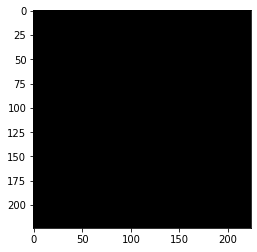

(11, 224, 224) AnnotatedCrop_3_6_1


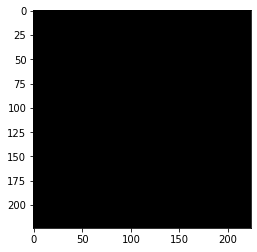

(11, 224, 224) AnnotatedCrop_3_6_2


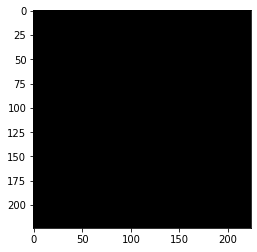

(11, 224, 224) AnnotatedCrop_3_6_3


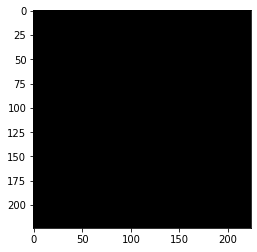

(11, 224, 224) AnnotatedCrop_3_6_4


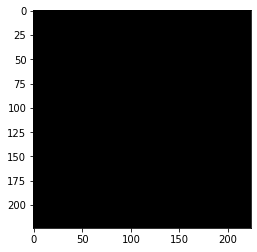

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_3_6_5


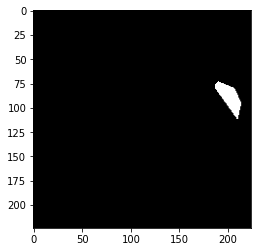

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_3_6_6


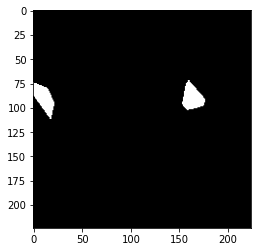

(11, 224, 224) AnnotatedCrop_3_6_7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


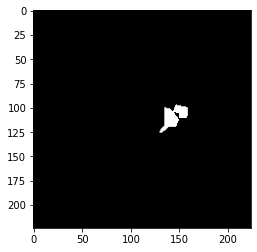

(11, 224, 224) AnnotatedCrop_3_6_8


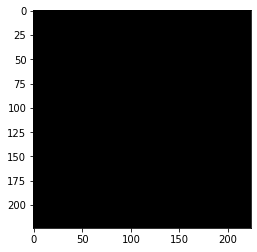

(11, 224, 224) AnnotatedCrop_3_6_9


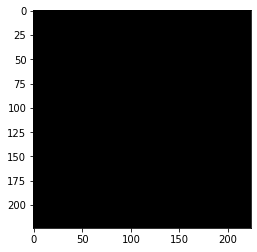

(11, 224, 224) AnnotatedCrop_3_6_10


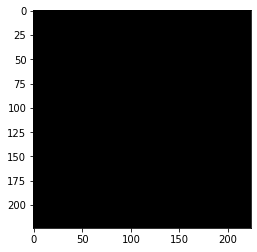

(11, 224, 224) AnnotatedCrop_3_6_11


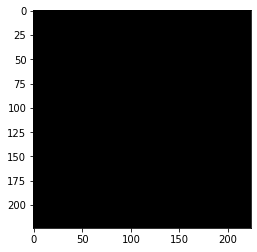

(11, 224, 192) AnnotatedCrop_3_6_12


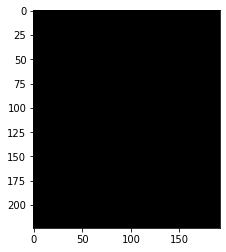

(11, 192, 224) AnnotatedCrop_3_7_0


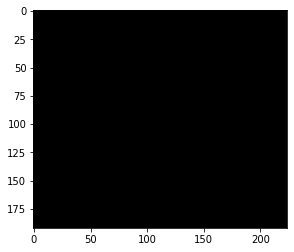

(11, 192, 224) AnnotatedCrop_3_7_1


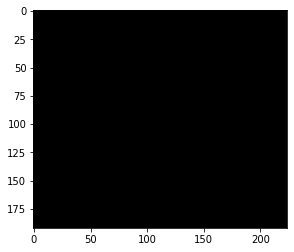

(11, 192, 224) AnnotatedCrop_3_7_2


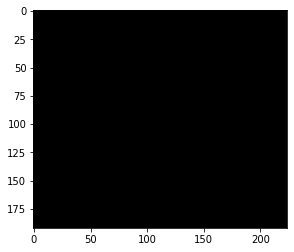

(11, 192, 224) AnnotatedCrop_3_7_3


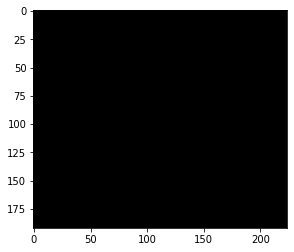

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 192, 224) AnnotatedCrop_3_7_4


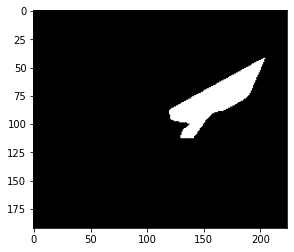

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 192, 224) AnnotatedCrop_3_7_5


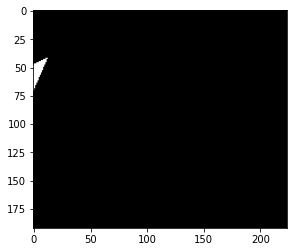

(11, 192, 224) AnnotatedCrop_3_7_6


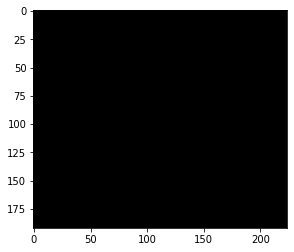

(11, 192, 224) AnnotatedCrop_3_7_7


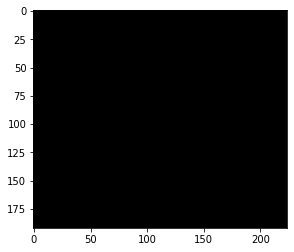

(11, 192, 224) AnnotatedCrop_3_7_8


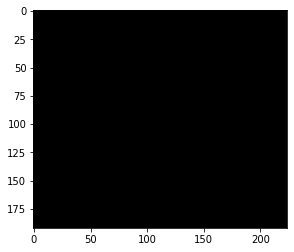

(11, 192, 224) AnnotatedCrop_3_7_9


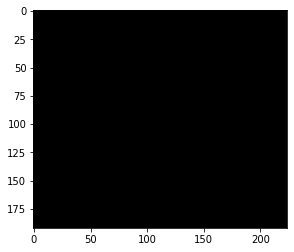

(11, 192, 224) AnnotatedCrop_3_7_10


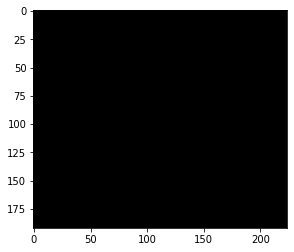

(11, 192, 224) AnnotatedCrop_3_7_11


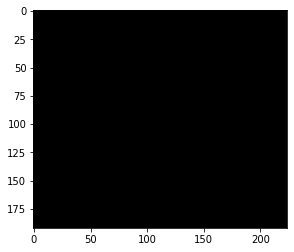

(11, 192, 192) AnnotatedCrop_3_7_12


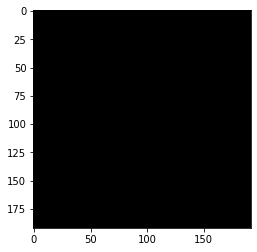

(11, 224, 224) AnnotatedCrop_4_0_0


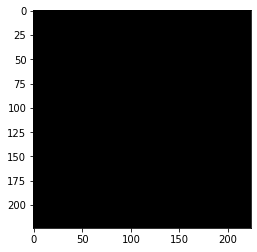

(11, 224, 224) AnnotatedCrop_4_0_1


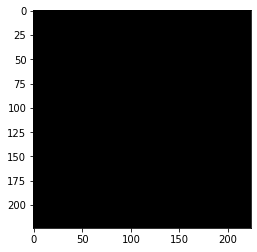

(11, 224, 224) AnnotatedCrop_4_0_2


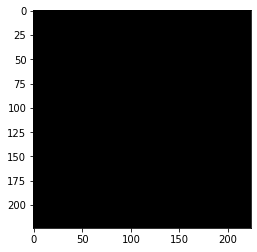

(11, 224, 224) AnnotatedCrop_4_0_3


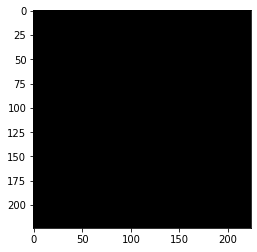

(11, 224, 224) 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AnnotatedCrop_4_0_4


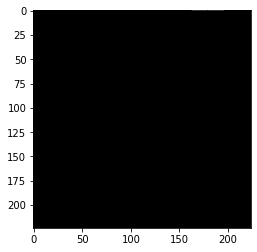

(11, 224, 224) AnnotatedCrop_4_0_5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


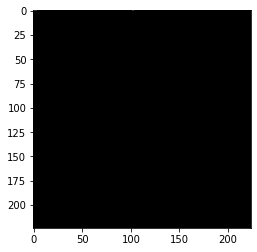

(11, 224, 224) AnnotatedCrop_4_0_6


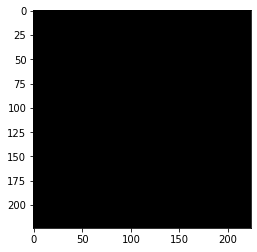

(11, 224, 224) AnnotatedCrop_4_0_7


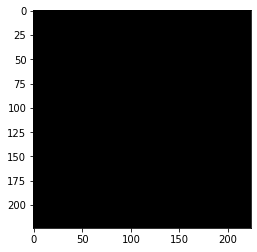

(11, 224, 224) AnnotatedCrop_4_0_8


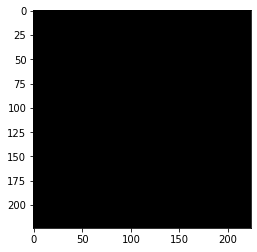

(11, 224, 224) AnnotatedCrop_4_0_9


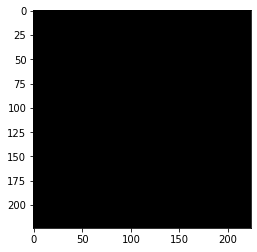

(11, 224, 224) AnnotatedCrop_4_0_10


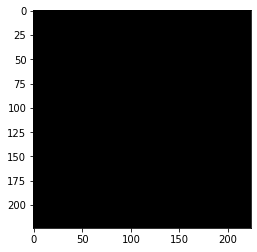

(11, 224, 224) AnnotatedCrop_4_0_11


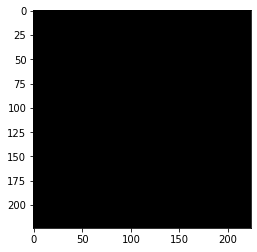

(11, 224, 192) AnnotatedCrop_4_0_12


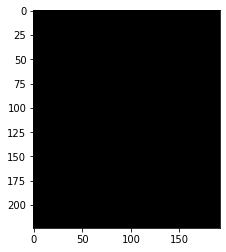

(11, 224, 224) AnnotatedCrop_4_1_0


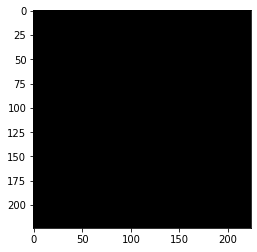

(11, 224, 224) AnnotatedCrop_4_1_1


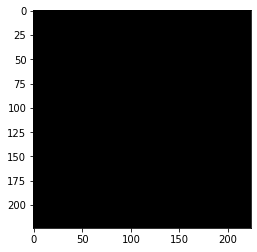

(11, 224, 224) AnnotatedCrop_4_1_2


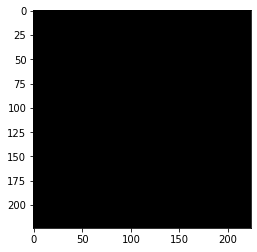

(11, 224, 224) AnnotatedCrop_4_1_3


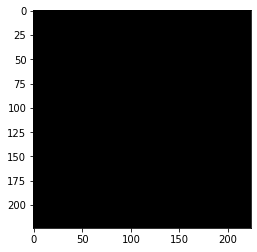

(11, 224, 224) AnnotatedCrop_4_1_4


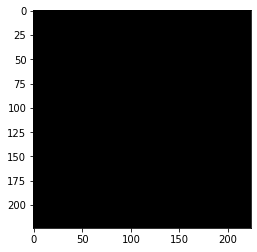

(11, 224, 224) AnnotatedCrop_4_1_5


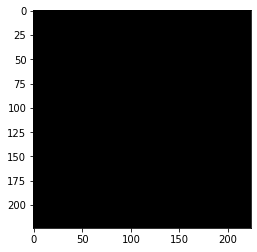

(11, 224, 224) AnnotatedCrop_4_1_6


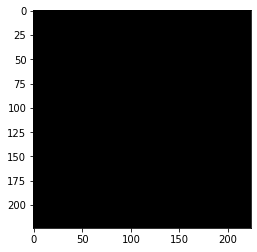

(11, 224, 224) AnnotatedCrop_4_1_7


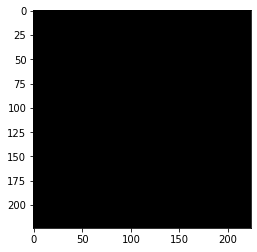

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_4_1_8


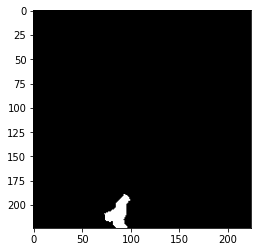

(11, 224, 224) AnnotatedCrop_4_1_9


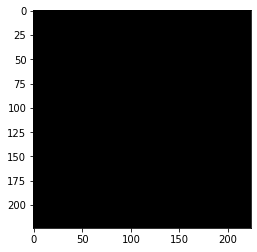

(11, 224, 224) AnnotatedCrop_4_1_10


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


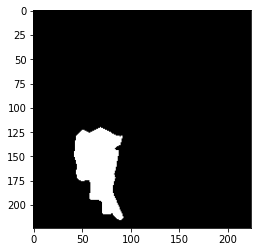

(11, 224, 224) AnnotatedCrop_4_1_11


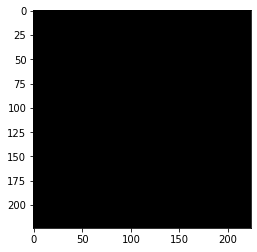

(11, 224, 192) AnnotatedCrop_4_1_12


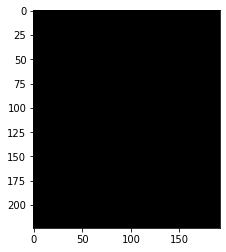

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_4_2_0


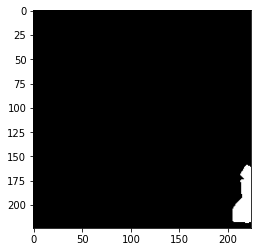

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_4_2_1


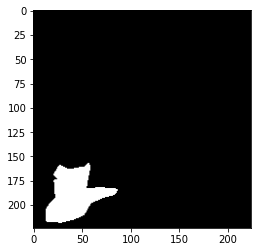

(11, 224, 224) AnnotatedCrop_4_2_2


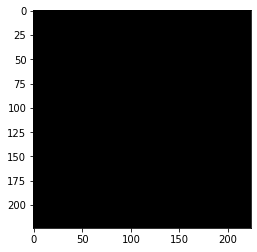

(11, 224, 224) AnnotatedCrop_4_2_3


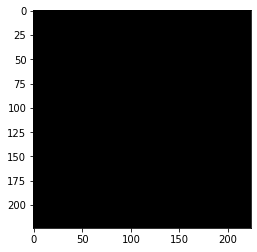

(11, 224, 224) AnnotatedCrop_4_2_4


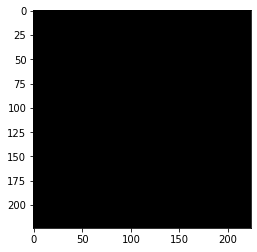

(11, 224, 224) AnnotatedCrop_4_2_5


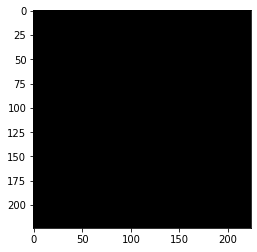

(11, 224, 224) AnnotatedCrop_4_2_6


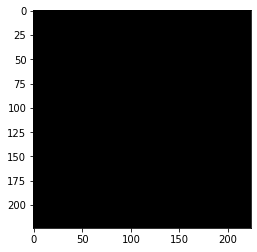

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_4_2_7


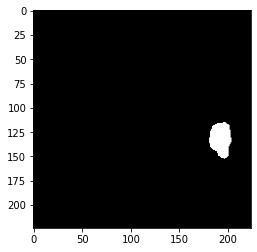

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_4_2_8


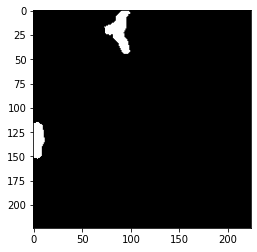

(11, 224, 224) AnnotatedCrop_4_2_9


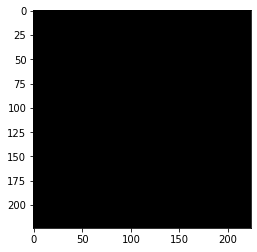

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_4_2_10


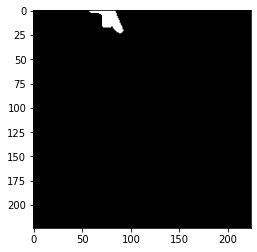

(11, 224, 224) AnnotatedCrop_4_2_11


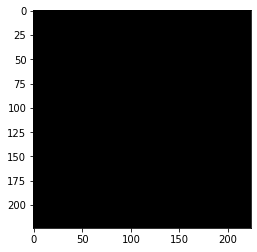

(11, 224, 192) AnnotatedCrop_4_2_12


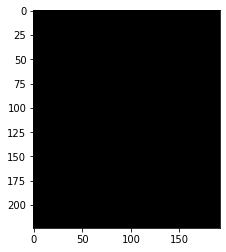

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_4_3_0


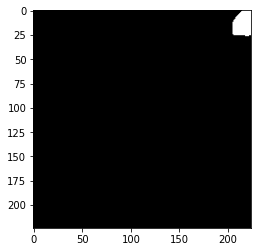

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_4_3_1


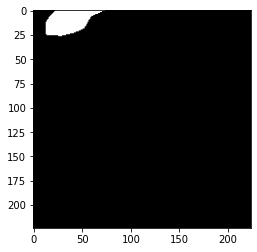

(11, 224, 224) AnnotatedCrop_4_3_2


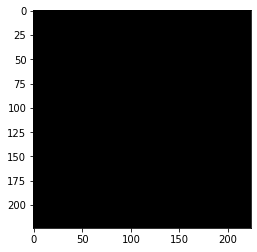

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_4_3_3


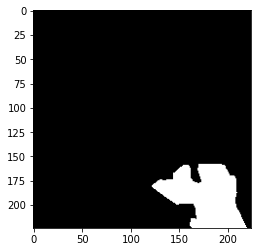

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_4_3_4


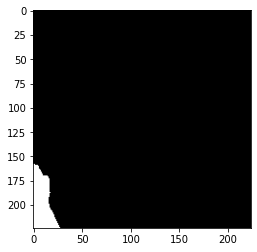

(11, 224, 224) AnnotatedCrop_4_3_5


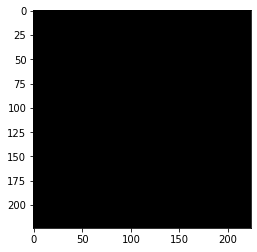

(11, 224, 224) AnnotatedCrop_4_3_6


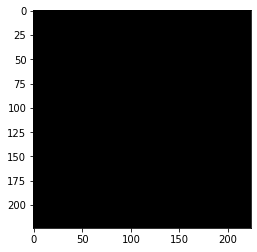

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_4_3_7


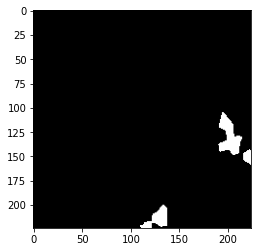

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_4_3_8


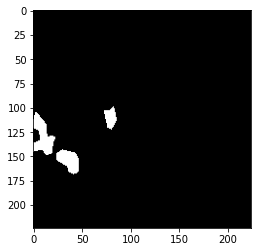

(11, 224, 224) AnnotatedCrop_4_3_9


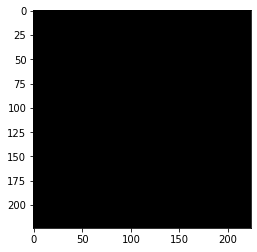

(11, 224, 224) AnnotatedCrop_4_3_10


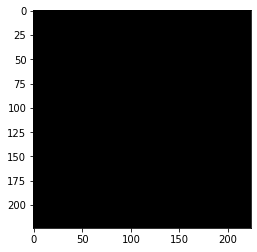

(11, 224, 224) AnnotatedCrop_4_3_11


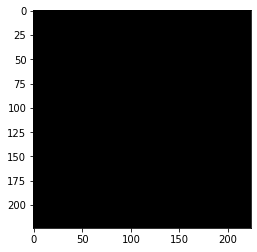

(11, 224, 192) AnnotatedCrop_4_3_12


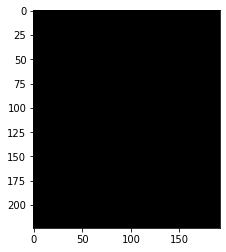

(11, 224, 224) AnnotatedCrop_4_4_0


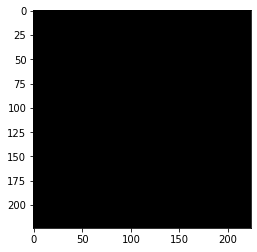

(11, 224, 224) AnnotatedCrop_4_4_1


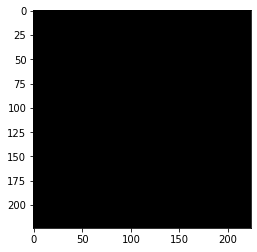

(11, 224, 224) AnnotatedCrop_4_4_2


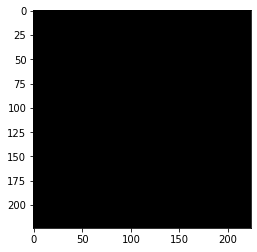

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_4_4_3


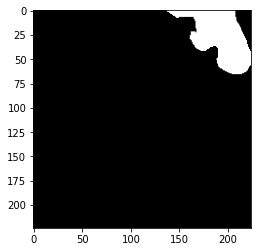

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_4_4_4


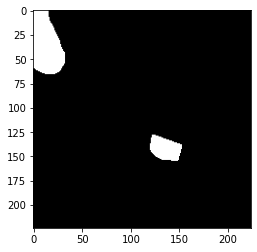

(11, 224, 224) AnnotatedCrop_4_4_5


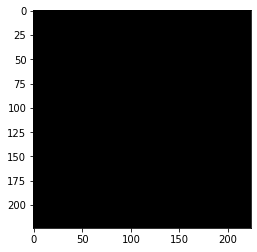

(11, 224, 224) AnnotatedCrop_4_4_6


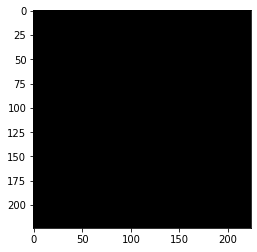

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_4_4_7


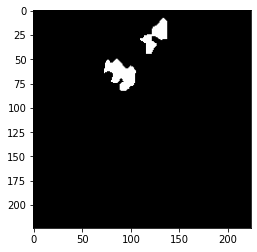

(11, 224, 224) AnnotatedCrop_4_4_8


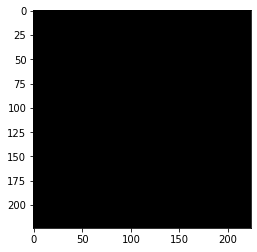

(11, 224, 224) AnnotatedCrop_4_4_9


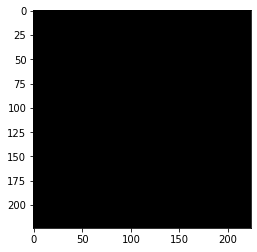

(11, 224, 224) AnnotatedCrop_4_4_10


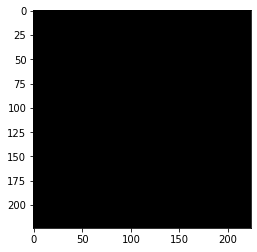

(11, 224, 224) AnnotatedCrop_4_4_11


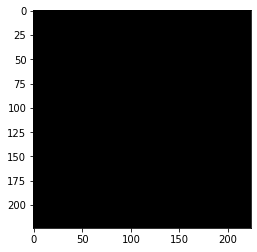

(11, 224, 192) AnnotatedCrop_4_4_12


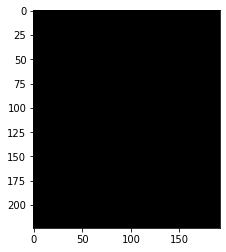

(11, 224, 224) AnnotatedCrop_4_5_0


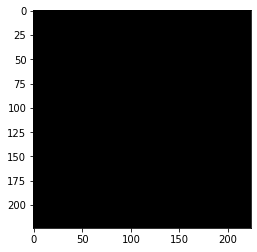

(11, 224, 224) AnnotatedCrop_4_5_1


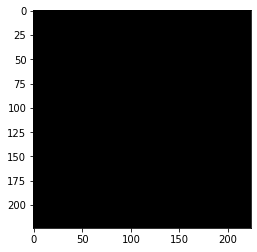

(11, 224, 224) AnnotatedCrop_4_5_2


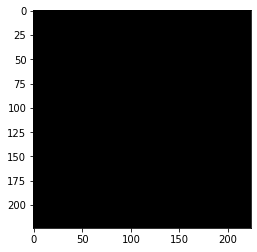

(11, 224, 224) AnnotatedCrop_4_5_3


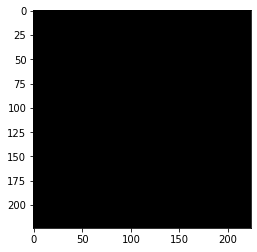

(11, 224, 224) AnnotatedCrop_4_5_4


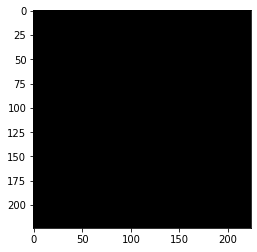

(11, 224, 224) AnnotatedCrop_4_5_5


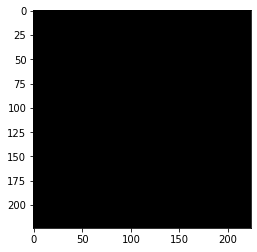

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_4_5_6


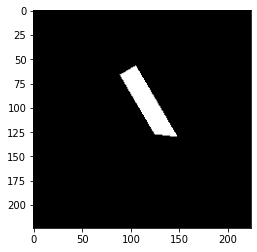

(11, 224, 224) AnnotatedCrop_4_5_7


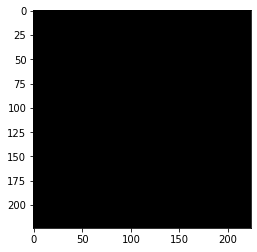

(11, 224, 224) AnnotatedCrop_4_5_8


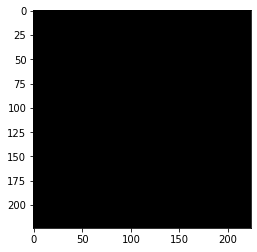

(11, 224, 224) AnnotatedCrop_4_5_9


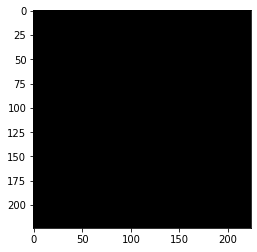

(11, 224, 224) AnnotatedCrop_4_5_10


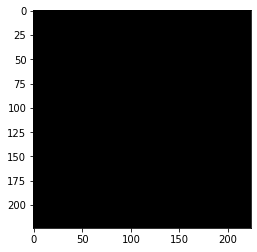

(11, 224, 224) AnnotatedCrop_4_5_11


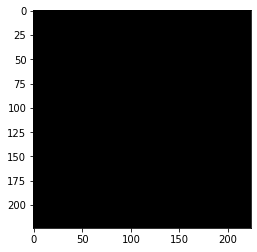

(11, 224, 192) AnnotatedCrop_4_5_12


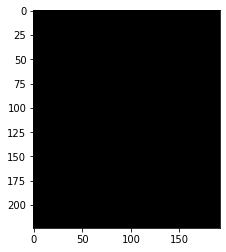

(11, 224, 224) AnnotatedCrop_4_6_0


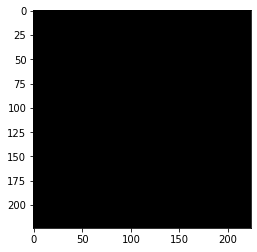

(11, 224, 224) AnnotatedCrop_4_6_1


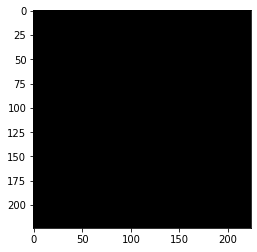

(11, 224, 224) AnnotatedCrop_4_6_2


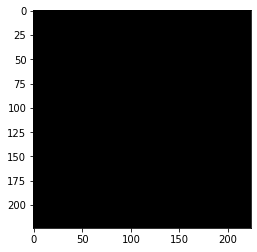

(11, 224, 224) AnnotatedCrop_4_6_3


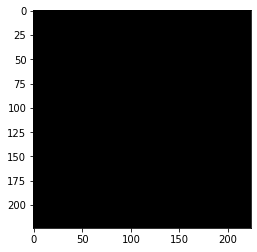

(11, 224, 224) AnnotatedCrop_4_6_4


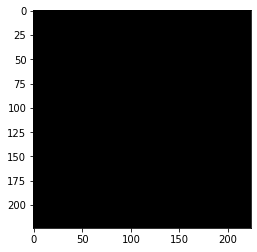

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_4_6_5


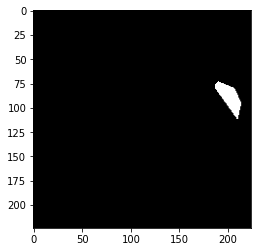

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_4_6_6


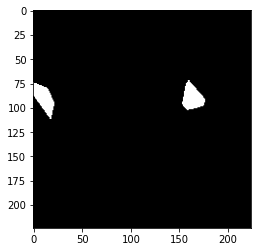

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_4_6_7


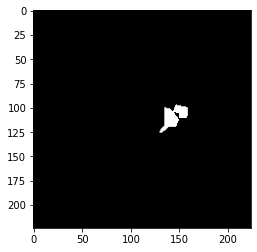

(11, 224, 224) AnnotatedCrop_4_6_8


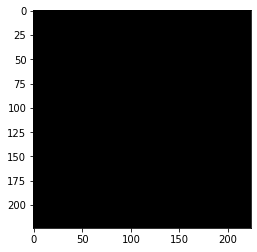

(11, 224, 224) AnnotatedCrop_4_6_9


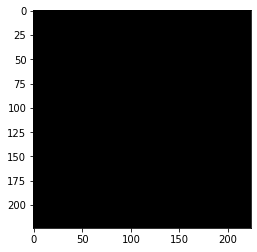

(11, 224, 224) AnnotatedCrop_4_6_10


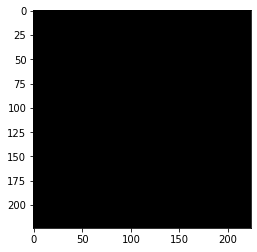

(11, 224, 224) AnnotatedCrop_4_6_11


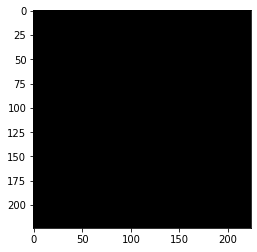

(11, 224, 192) AnnotatedCrop_4_6_12


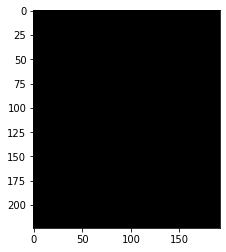

(11, 192, 224) AnnotatedCrop_4_7_0


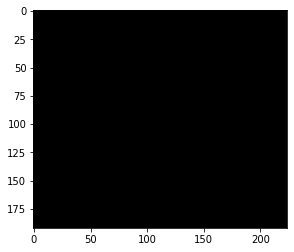

(11, 192, 224) AnnotatedCrop_4_7_1


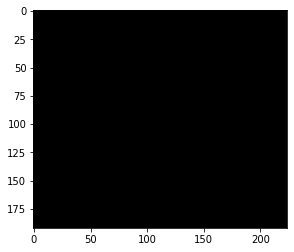

(11, 192, 224) AnnotatedCrop_4_7_2


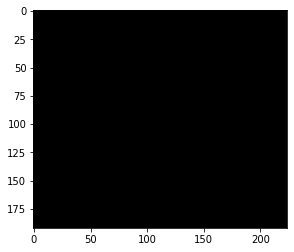

(11, 192, 224) AnnotatedCrop_4_7_3


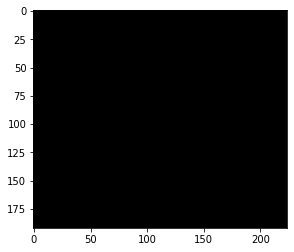

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 192, 224) AnnotatedCrop_4_7_4


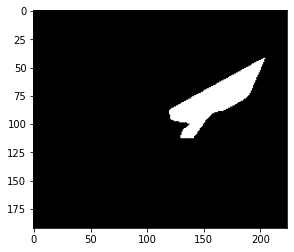

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 192, 224) AnnotatedCrop_4_7_5


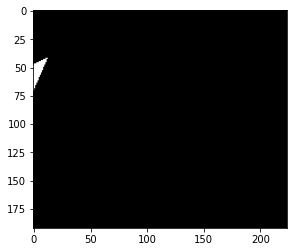

(11, 192, 224) AnnotatedCrop_4_7_6


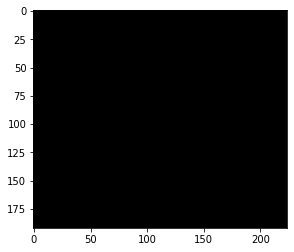

(11, 192, 224) AnnotatedCrop_4_7_7


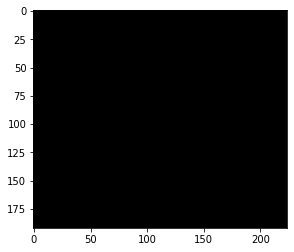

(11, 192, 224) AnnotatedCrop_4_7_8


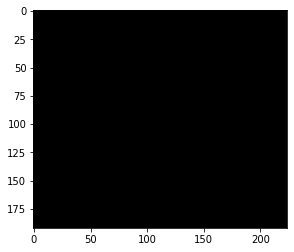

(11, 192, 224) AnnotatedCrop_4_7_9


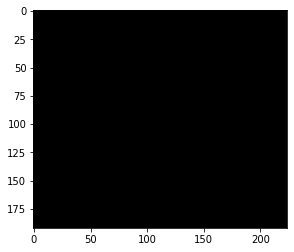

(11, 192, 224) AnnotatedCrop_4_7_10


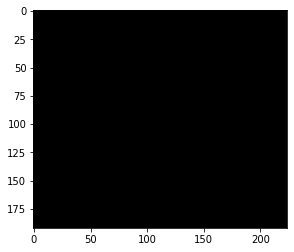

(11, 192, 224) AnnotatedCrop_4_7_11


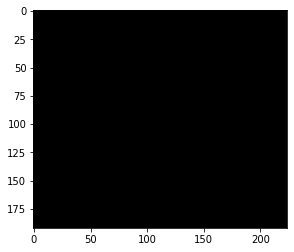

(11, 192, 192) AnnotatedCrop_4_7_12


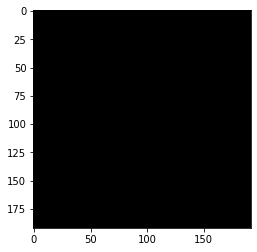

(11, 224, 224) AnnotatedCrop_5_0_0


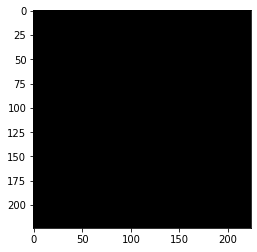

(11, 224, 224) AnnotatedCrop_5_0_1


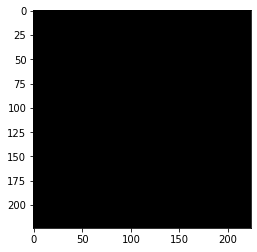

(11, 224, 224) AnnotatedCrop_5_0_2


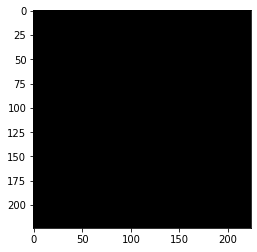

(11, 224, 224) AnnotatedCrop_5_0_3


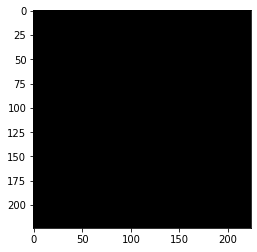

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_5_0_4


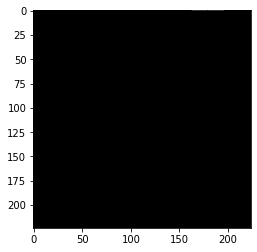

(11, 224, 224) AnnotatedCrop_5_0_5


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


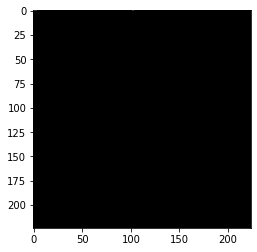

(11, 224, 224) AnnotatedCrop_5_0_6


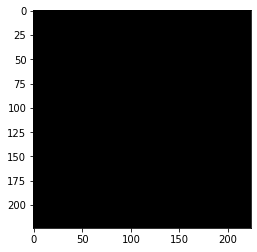

(11, 224, 224) AnnotatedCrop_5_0_7


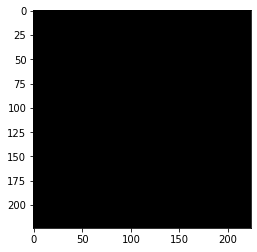

(11, 224, 224) AnnotatedCrop_5_0_8


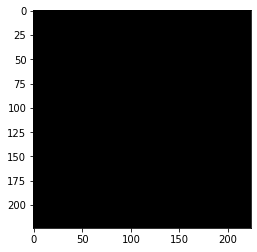

(11, 224, 224) AnnotatedCrop_5_0_9


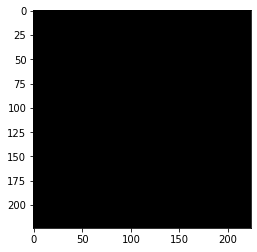

(11, 224, 224) AnnotatedCrop_5_0_10


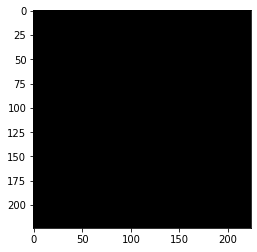

(11, 224, 224) AnnotatedCrop_5_0_11


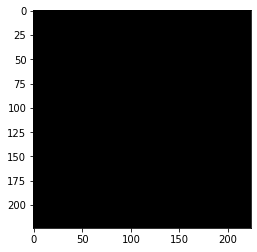

(11, 224, 192) AnnotatedCrop_5_0_12


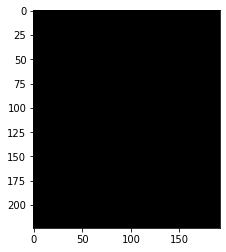

(11, 224, 224) AnnotatedCrop_5_1_0


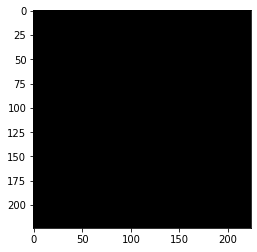

(11, 224, 224) AnnotatedCrop_5_1_1


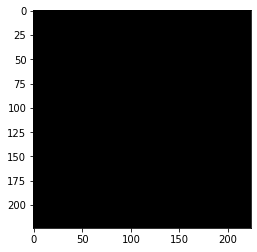

(11, 224, 224) AnnotatedCrop_5_1_2


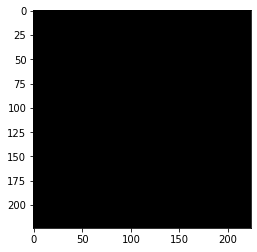

(11, 224, 224) AnnotatedCrop_5_1_3


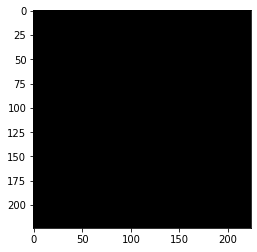

(11, 224, 224) AnnotatedCrop_5_1_4


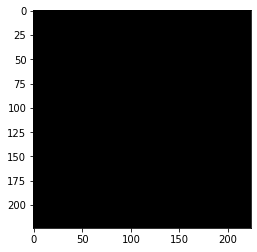

(11, 224, 224) AnnotatedCrop_5_1_5


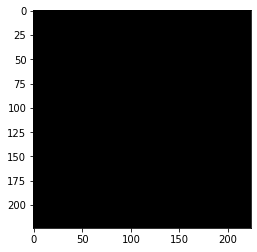

(11, 224, 224) AnnotatedCrop_5_1_6


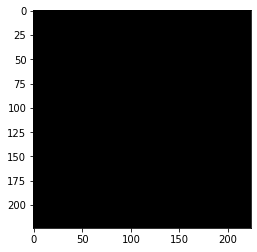

(11, 224, 224) AnnotatedCrop_5_1_7


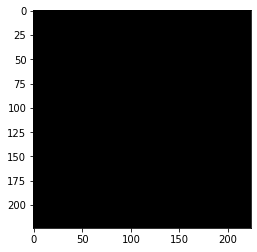

(11, 224, 224) AnnotatedCrop_5_1_8


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


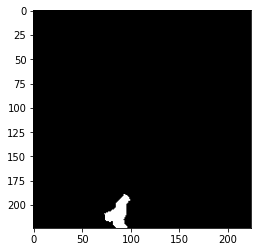

(11, 224, 224) AnnotatedCrop_5_1_9


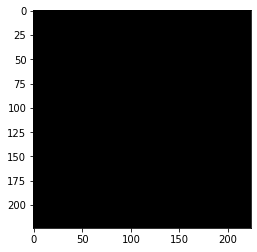

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_5_1_10


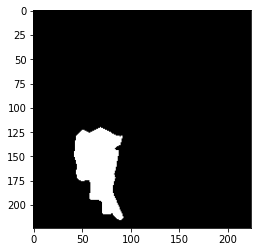

(11, 224, 224) AnnotatedCrop_5_1_11


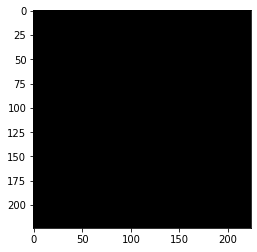

(11, 224, 192) AnnotatedCrop_5_1_12


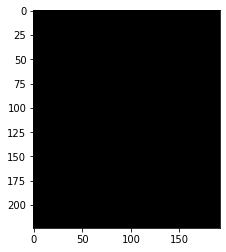

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_5_2_0


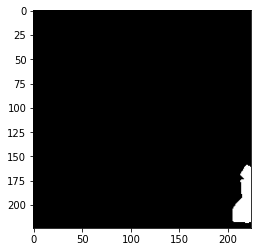

(11, 224, 224) AnnotatedCrop_5_2_1


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


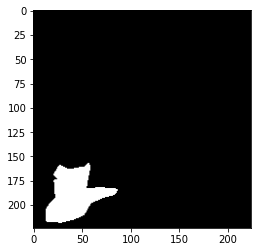

(11, 224, 224) AnnotatedCrop_5_2_2


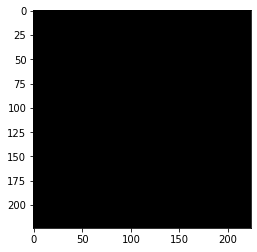

(11, 224, 224) AnnotatedCrop_5_2_3


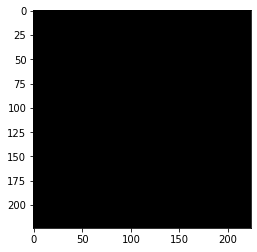

(11, 224, 224) AnnotatedCrop_5_2_4


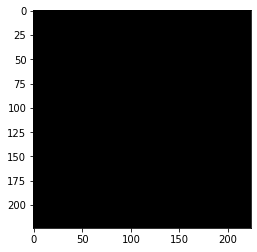

(11, 224, 224) AnnotatedCrop_5_2_5


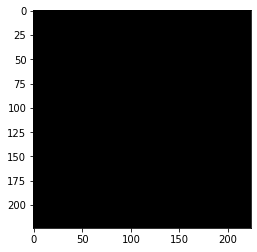

(11, 224, 224) AnnotatedCrop_5_2_6


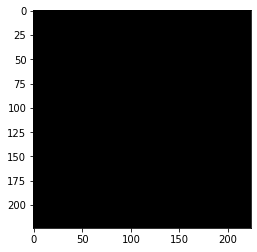

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_5_2_7


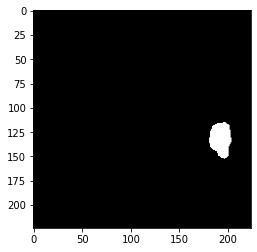

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_5_2_8


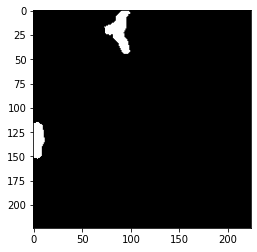

(11, 224, 224) AnnotatedCrop_5_2_9


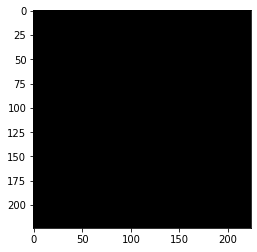

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_5_2_10


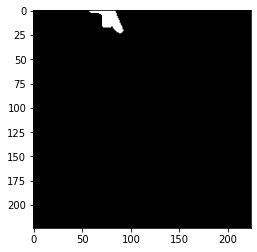

(11, 224, 224) AnnotatedCrop_5_2_11


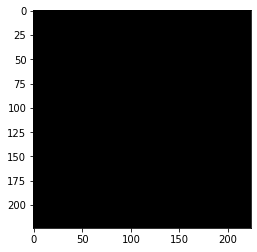

(11, 224, 192) AnnotatedCrop_5_2_12


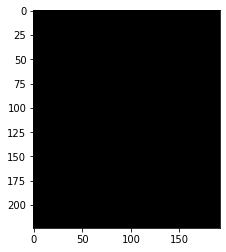

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_5_3_0


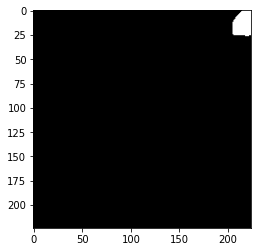

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_5_3_1


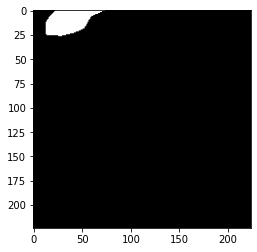

(11, 224, 224) AnnotatedCrop_5_3_2


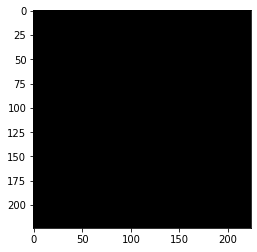

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_5_3_3


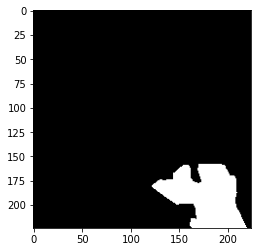

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_5_3_4


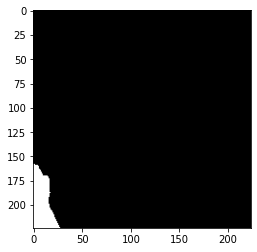

(11, 224, 224) AnnotatedCrop_5_3_5


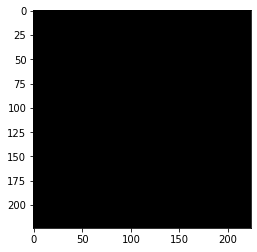

(11, 224, 224) AnnotatedCrop_5_3_6


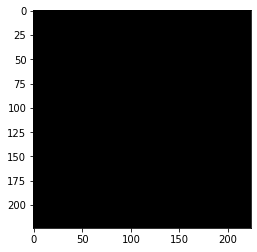

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_5_3_7


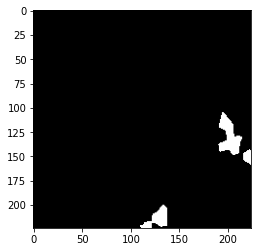

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_5_3_8


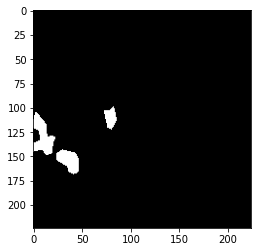

(11, 224, 224) AnnotatedCrop_5_3_9


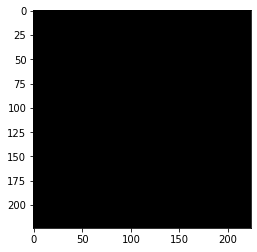

(11, 224, 224) AnnotatedCrop_5_3_10


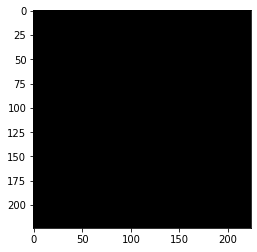

(11, 224, 224) AnnotatedCrop_5_3_11


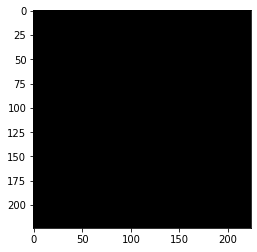

(11, 224, 192) AnnotatedCrop_5_3_12


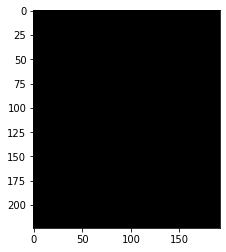

(11, 224, 224) AnnotatedCrop_5_4_0


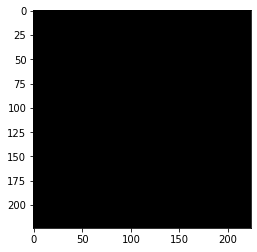

(11, 224, 224) AnnotatedCrop_5_4_1


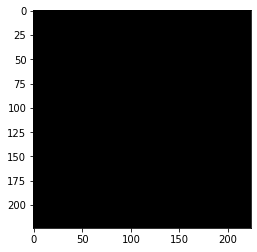

(11, 224, 224) AnnotatedCrop_5_4_2


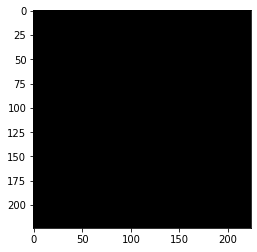

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_5_4_3


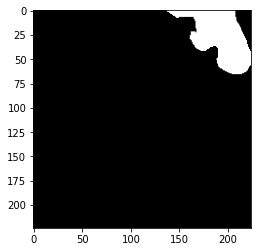

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_5_4_4


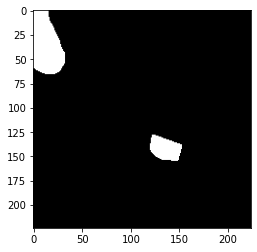

(11, 224, 224) AnnotatedCrop_5_4_5


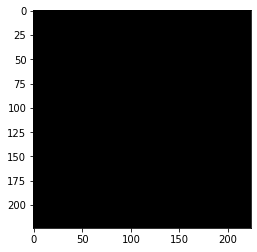

(11, 224, 224) AnnotatedCrop_5_4_6


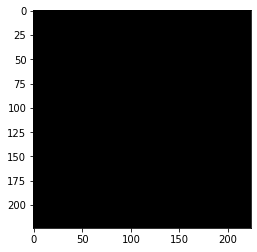

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_5_4_7


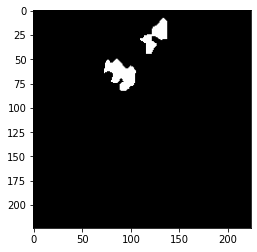

(11, 224, 224) AnnotatedCrop_5_4_8


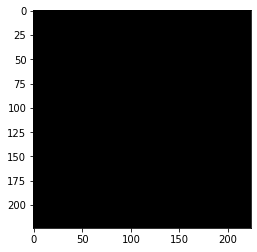

(11, 224, 224) AnnotatedCrop_5_4_9


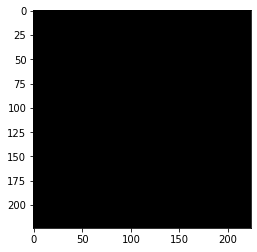

(11, 224, 224) AnnotatedCrop_5_4_10


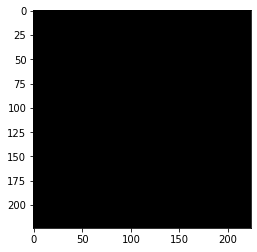

(11, 224, 224) AnnotatedCrop_5_4_11


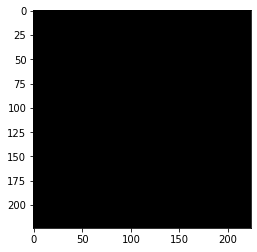

(11, 224, 192) AnnotatedCrop_5_4_12


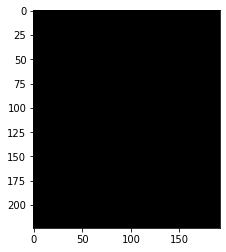

(11, 224, 224) AnnotatedCrop_5_5_0


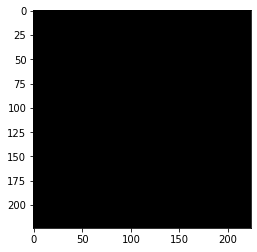

(11, 224, 224) AnnotatedCrop_5_5_1


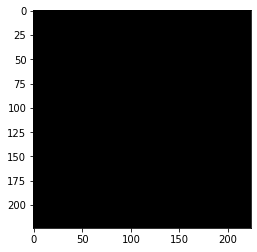

(11, 224, 224) AnnotatedCrop_5_5_2


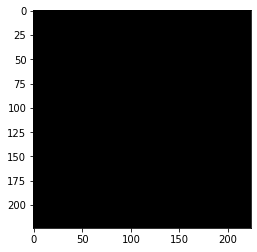

(11, 224, 224) AnnotatedCrop_5_5_3


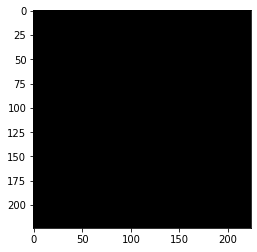

(11, 224, 224) AnnotatedCrop_5_5_4


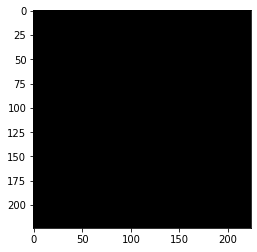

(11, 224, 224) AnnotatedCrop_5_5_5


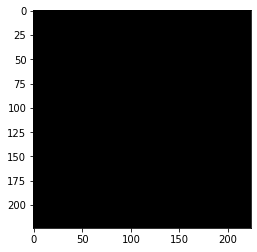

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_5_5_6


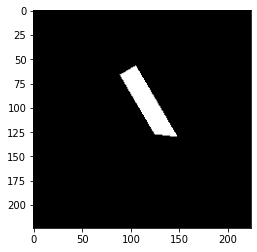

(11, 224, 224) AnnotatedCrop_5_5_7


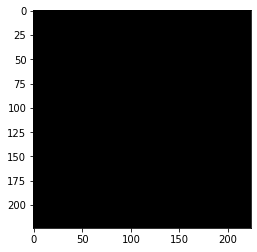

(11, 224, 224) AnnotatedCrop_5_5_8


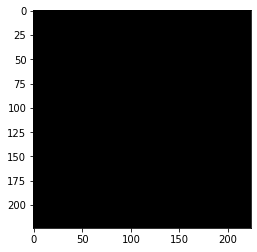

(11, 224, 224) AnnotatedCrop_5_5_9


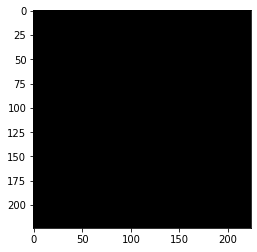

(11, 224, 224) AnnotatedCrop_5_5_10


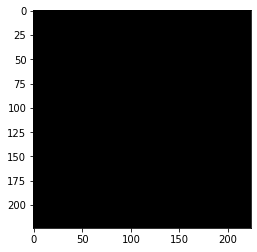

(11, 224, 224) AnnotatedCrop_5_5_11


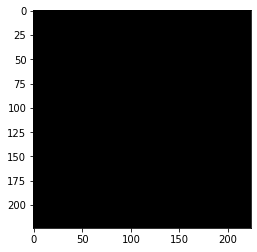

(11, 224, 192) AnnotatedCrop_5_5_12


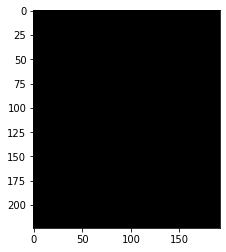

(11, 224, 224) AnnotatedCrop_5_6_0


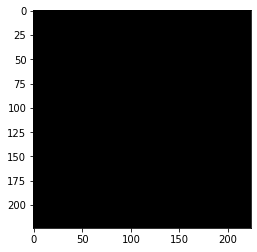

(11, 224, 224) AnnotatedCrop_5_6_1


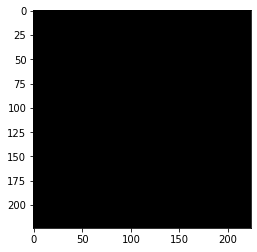

(11, 224, 224) AnnotatedCrop_5_6_2


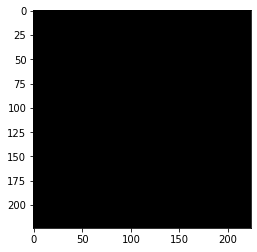

(11, 224, 224) AnnotatedCrop_5_6_3


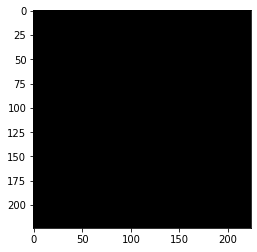

(11, 224, 224) AnnotatedCrop_5_6_4


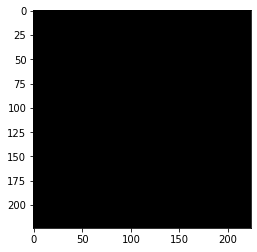

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_5_6_5


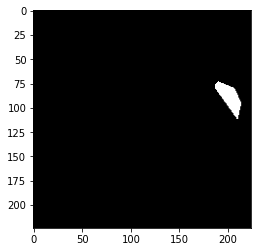

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_5_6_6


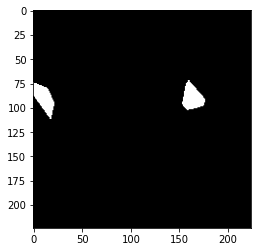

(11, 224, 224) AnnotatedCrop_5_6_7


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


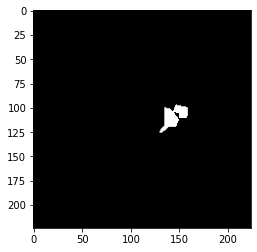

(11, 224, 224) AnnotatedCrop_5_6_8


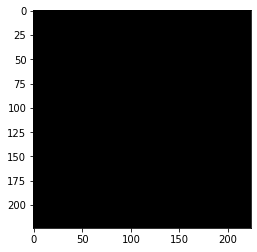

(11, 224, 224) AnnotatedCrop_5_6_9


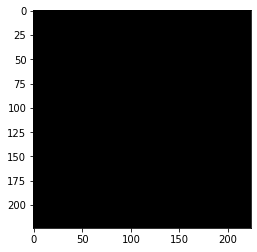

(11, 224, 224) AnnotatedCrop_5_6_10


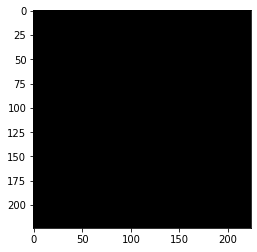

(11, 224, 224) AnnotatedCrop_5_6_11


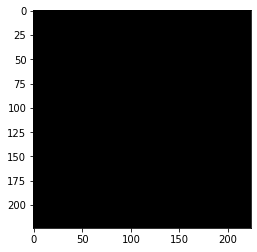

(11, 224, 192) AnnotatedCrop_5_6_12


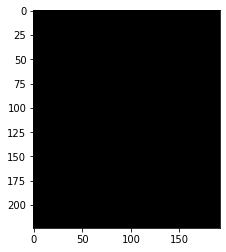

(11, 192, 224) AnnotatedCrop_5_7_0


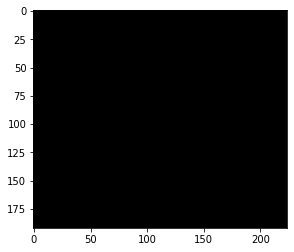

(11, 192, 224) AnnotatedCrop_5_7_1


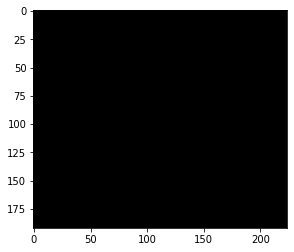

(11, 192, 224) AnnotatedCrop_5_7_2


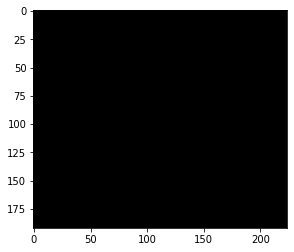

(11, 192, 224) AnnotatedCrop_5_7_3


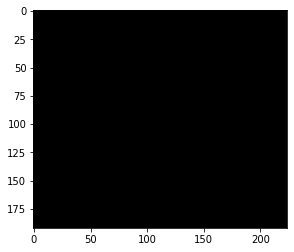

(11, 192, 224) AnnotatedCrop_5_7_4


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


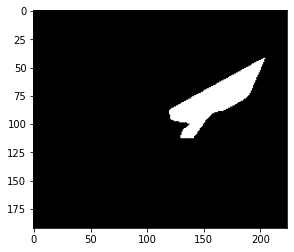

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 192, 224) AnnotatedCrop_5_7_5


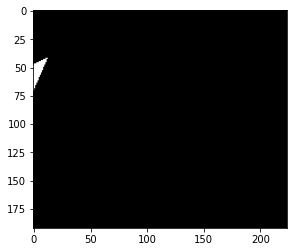

(11, 192, 224) AnnotatedCrop_5_7_6


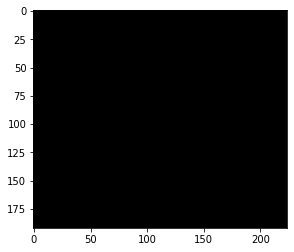

(11, 192, 224) AnnotatedCrop_5_7_7


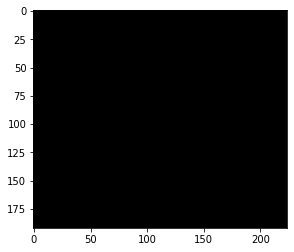

(11, 192, 224) AnnotatedCrop_5_7_8


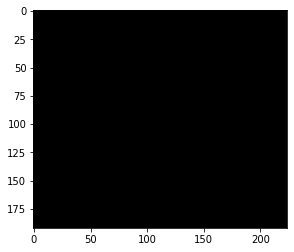

(11, 192, 224) AnnotatedCrop_5_7_9


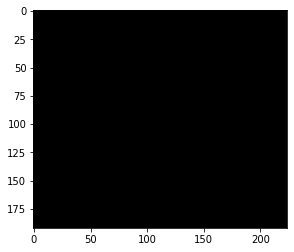

(11, 192, 224) AnnotatedCrop_5_7_10


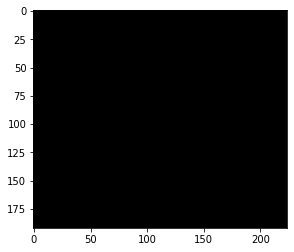

(11, 192, 224) AnnotatedCrop_5_7_11


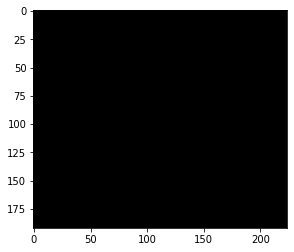

(11, 192, 192) AnnotatedCrop_5_7_12


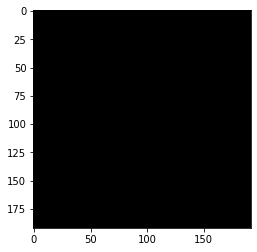

(11, 224, 224) AnnotatedCrop_6_0_0


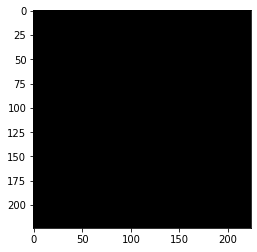

(11, 224, 224) AnnotatedCrop_6_0_1


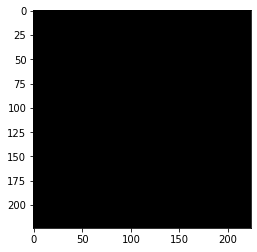

(11, 224, 224) AnnotatedCrop_6_0_2


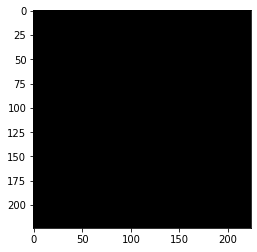

(11, 224, 224) AnnotatedCrop_6_0_3


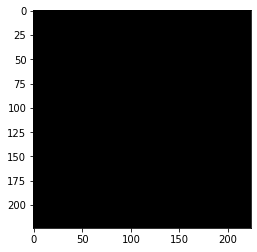

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_6_0_4


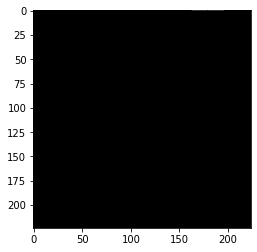

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_6_0_5


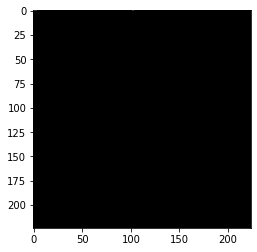

(11, 224, 224) AnnotatedCrop_6_0_6


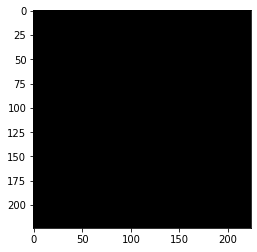

(11, 224, 224) AnnotatedCrop_6_0_7


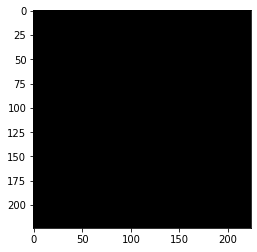

(11, 224, 224) AnnotatedCrop_6_0_8


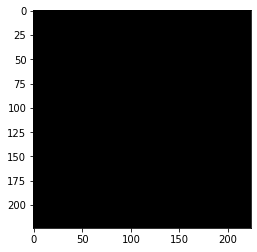

(11, 224, 224) AnnotatedCrop_6_0_9


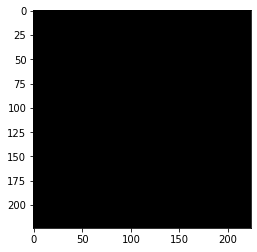

(11, 224, 224) AnnotatedCrop_6_0_10


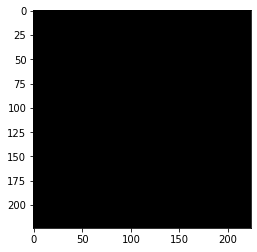

(11, 224, 224) AnnotatedCrop_6_0_11


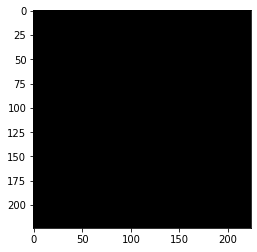

(11, 224, 192) AnnotatedCrop_6_0_12


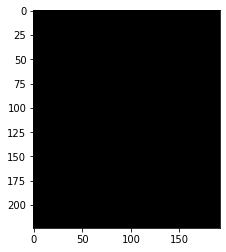

(11, 224, 224) AnnotatedCrop_6_1_0


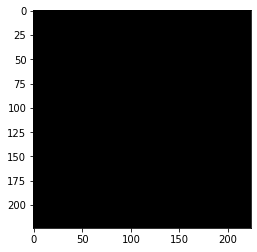

(11, 224, 224) AnnotatedCrop_6_1_1


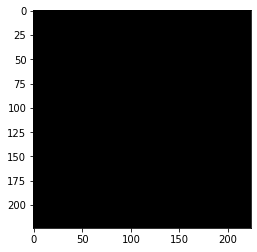

(11, 224, 224) AnnotatedCrop_6_1_2


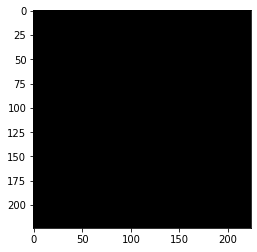

(11, 224, 224) AnnotatedCrop_6_1_3


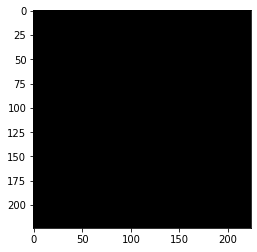

(11, 224, 224) AnnotatedCrop_6_1_4


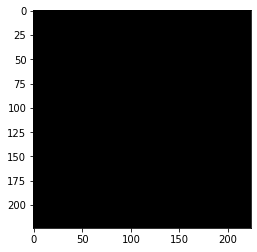

(11, 224, 224) AnnotatedCrop_6_1_5


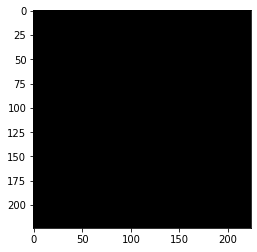

(11, 224, 224) AnnotatedCrop_6_1_6


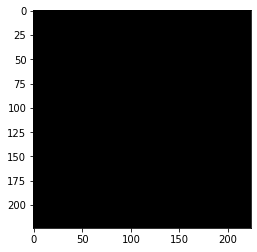

(11, 224, 224) AnnotatedCrop_6_1_7


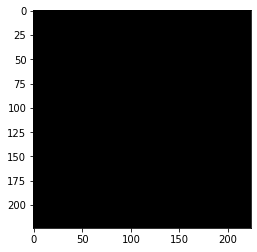

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_6_1_8


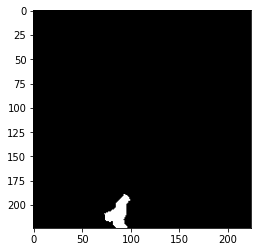

(11, 224, 224) AnnotatedCrop_6_1_9


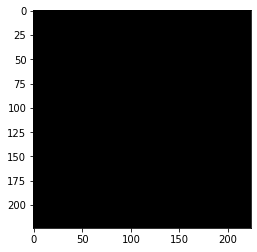

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_6_1_10


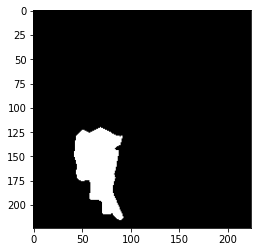

(11, 224, 224) AnnotatedCrop_6_1_11


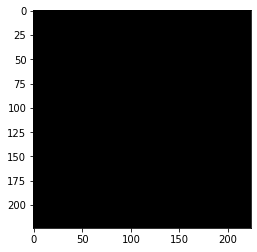

(11, 224, 192) AnnotatedCrop_6_1_12


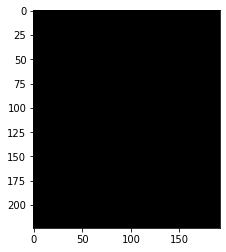

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_6_2_0


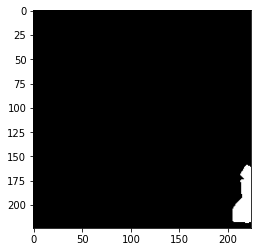

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_6_2_1


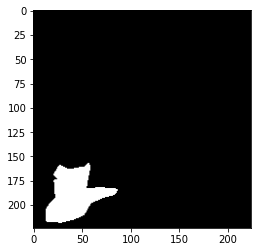

(11, 224, 224) AnnotatedCrop_6_2_2


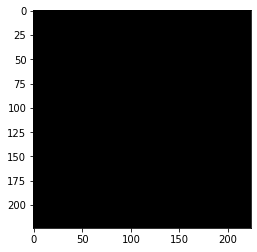

(11, 224, 224) AnnotatedCrop_6_2_3


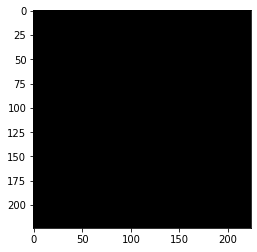

(11, 224, 224) AnnotatedCrop_6_2_4


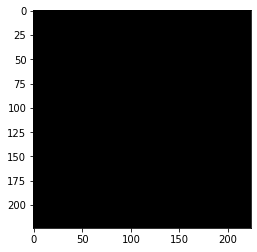

(11, 224, 224) AnnotatedCrop_6_2_5


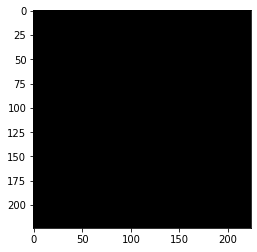

(11, 224, 224) AnnotatedCrop_6_2_6


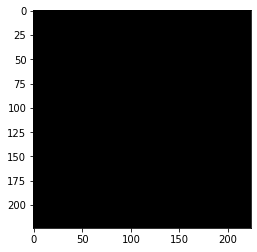

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_6_2_7


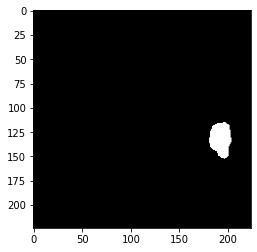

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_6_2_8


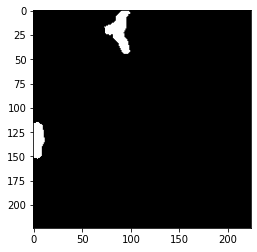

(11, 224, 224) AnnotatedCrop_6_2_9


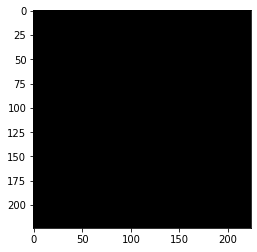

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_6_2_10


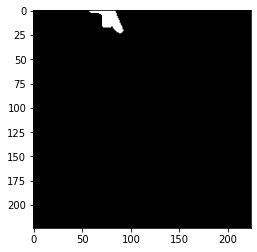

(11, 224, 224) AnnotatedCrop_6_2_11


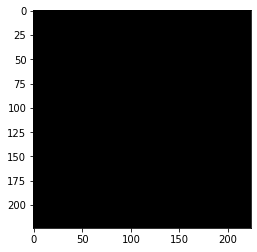

(11, 224, 192) AnnotatedCrop_6_2_12


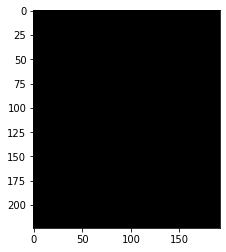

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_6_3_0


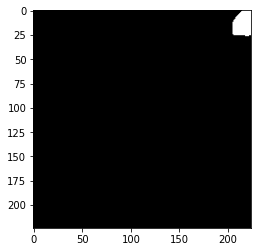

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_6_3_1


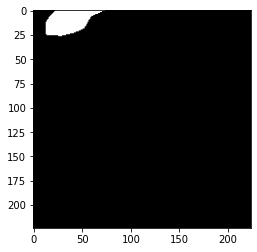

(11, 224, 224) AnnotatedCrop_6_3_2


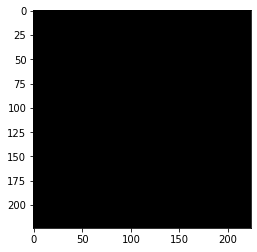

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_6_3_3


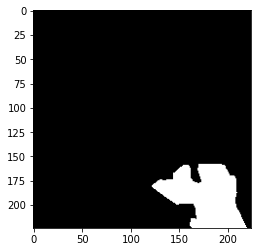

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_6_3_4


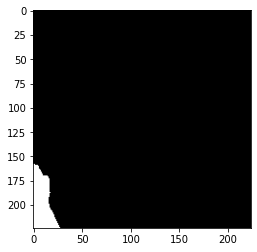

(11, 224, 224) AnnotatedCrop_6_3_5


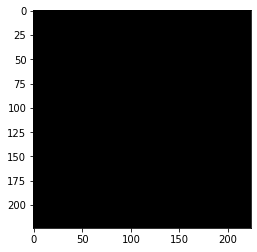

(11, 224, 224) AnnotatedCrop_6_3_6


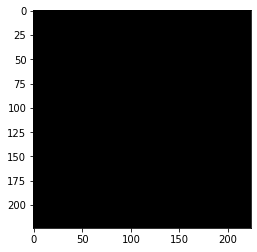

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_6_3_7


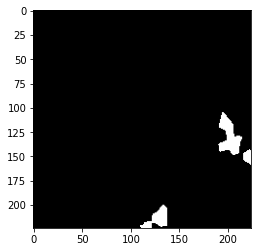

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_6_3_8


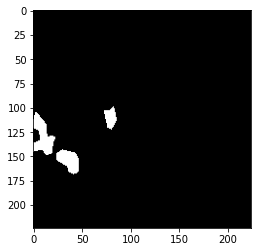

(11, 224, 224) AnnotatedCrop_6_3_9


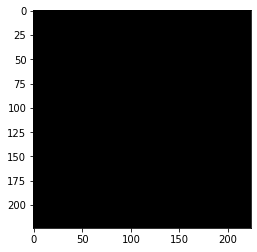

(11, 224, 224) AnnotatedCrop_6_3_10


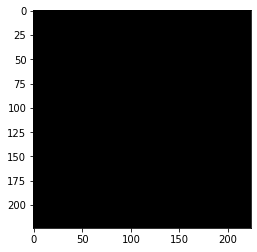

(11, 224, 224) AnnotatedCrop_6_3_11


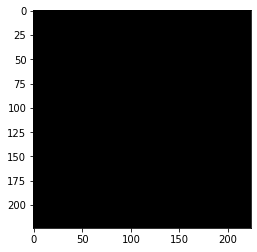

(11, 224, 192) AnnotatedCrop_6_3_12


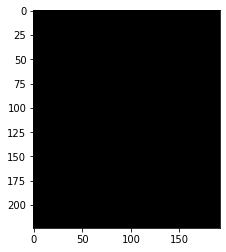

(11, 224, 224) AnnotatedCrop_6_4_0


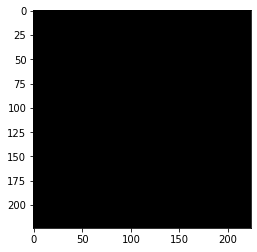

(11, 224, 224) AnnotatedCrop_6_4_1


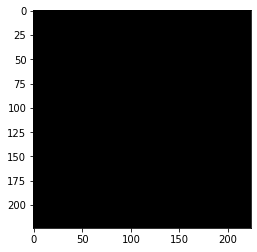

(11, 224, 224) AnnotatedCrop_6_4_2


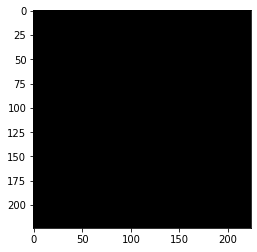

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_6_4_3


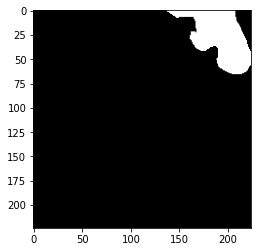

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_6_4_4


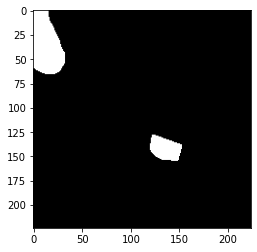

(11, 224, 224) AnnotatedCrop_6_4_5


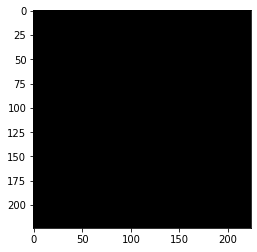

(11, 224, 224) AnnotatedCrop_6_4_6


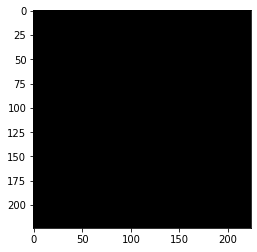

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(11, 224, 224) AnnotatedCrop_6_4_7


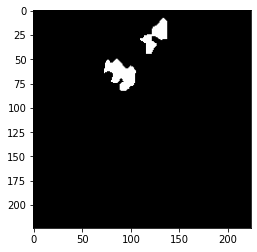

(11, 224, 224) AnnotatedCrop_6_4_8


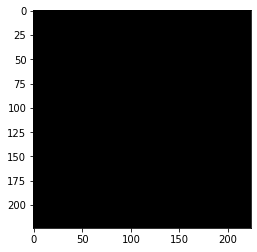

(11, 224, 224) AnnotatedCrop_6_4_9


In [ ]:
for i in range(0,10):
  for j in range(0,8):
    for k in range(0,13):
      img = processCropSaveImage('./drive/My Drive/Datasets/Project/groundTruth/annotation.tiff',0+(192 * k),0 + (192 * j),224,224,'./drive/My Drive/Datasets/Project/croppedGroundTruth/','AnnotatedCrop','{}_{}_{}'.format(i,j,k))
      img = np.transpose(img,(0,1,2))
      print(img.shape,'AnnotatedCrop_{}_{}_{}'.format(i,j,k))
      plot.show(img[0:3])


In [ ]:
root = './drive/My Drive/Datasets/Project/tiffFiles/'
imgNames = [f.name for f in os.scandir('./drive/My Drive/Datasets/Project/tiffFiles/')]
len(imgNames)

22

In [ ]:
for i in range(len(imgNames)):
  for j in range(0,8):
    for k in range(0,13):
      processCropSaveImage(os.path.join(root,imgNames[i]),0+(192 * k),0 + (192 * j),224,224,'./drive/My Drive/Datasets/Project/croppedImages/','ImageCrop','{}_{}_{}'.format(i,j,k))
      plot.show(rgb)

/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:232: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  **kwargs)


In [ ]:
path = './drive/My Drive/Datasets/Project/croppedImages/'
imgNames = [f.name for f in os.scandir('./drive/My Drive/Datasets/Project/croppedImages/')]

In [ ]:
len(imgNames)

1040

In [ ]:
# imgNames = [f.name for f in os.scandir('./drive/My Drive/Datasets/Project/pngCroppedImages/')]
# len(imgNames)

In [ ]:
def processConvertImage(path,dest,name):
  with rasterio.open(path,count=3) as src:
    w_1 = src.read(1)
    w_2 = src.read(2)
    w_3 = src.read(3)
  image = np.array([w_1,w_2,w_3])
  # p2, p98 = np.percentile(image, (2,98))
  # image = exposure.rescale_intensity(image, in_range=(p2, p98)) / 100000

  rgb = ((np.clip(image.copy(),0,1))*255).astype('uint8')
  rgb = np.transpose(rgb,(1,2,0))
  img = Image.fromarray(rgb, 'RGB')
  img.save('{}{}.png'.format(dest,name))

  return image

In [ ]:
for i in range(len(imgNames)):
  processConvertImage(os.path.join(path,imgNames[i]),'./drive/My Drive/Datasets/Project/pngCroppedImages/',imgNames[i][:-5])

/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
path = './drive/My Drive/Datasets/Project/pngCroppedImages/'
imgNames = [f.name for f in os.scandir('./drive/My Drive/Datasets/Project/pngCroppedImages/')]
len(imgNames)

1040

In [ ]:
for i in range(len(imgNames)):
  fig = plt.figure()
  img = Image.open(os.path.join(path,imgNames[i]))
  img = np.asarray(img)
  plt.title('Image: {}'.format(imgNames[i]))
  plt.imshow(img)
  if i == 103:
    break

In [ ]:
path = './drive/My Drive/Datasets/Project/croppedGroundTruth/'
imgNames = [f.name for f in os.scandir('./drive/My Drive/Datasets/Project/croppedGroundTruth/')]
len(imgNames)

1040

In [ ]:
for i in range(len(imgNames)):
  processConvertImage(os.path.join(path,imgNames[i]),'./drive/My Drive/Datasets/Project/pngGroundTruth/',imgNames[i][:-5])

/usr/local/lib/python3.6/dist-packages/rasterio/__init__.py:218: NotGeoreferencedWarning: Dataset has no geotransform set. The identity matrix may be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [ ]:
path = './drive/My Drive/Datasets/Project/pngGroundTruth/'
imgNames = [f.name for f in os.scandir('./drive/My Drive/Datasets/Project/pngGroundTruth/')]
len(imgNames)

1040

In [ ]:
path = './drive/My Drive/'
imgNames = [f.name for f in os.scandir('./drive/My Drive/')]
for i in range(len(imgNames)):
  if re.search('ImageCrop.*',imgNames[i]):
    os.remove(os.path.join(path,imgNames[i]))

In [ ]:
imgNames = [f.name for f in os.scandir('./drive/My Drive/')]
len(imgNames)

7

In [ ]:
for i in range(len(imgNames)):
  fig = plt.figure()
  img = Image.open(os.path.join(path,imgNames[i]))
  img = np.asarray(img)
  plt.title('Image: {}'.format(imgNames[i]))
  plt.imshow(img)
  if i == 103:
    break

In [ ]:
input_dir = "./drive/My Drive/Datasets/Project/pngCroppedImages/"
target_dir = "./drive/My Drive/Datasets/Project/pngGroundTruth/"
img_size = (224, 224)
num_classes = 2
batch_size = 32

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".png")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png")
    ]
)

print("Number of samples:", len(input_img_paths))
print("Number of samples:", len(target_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[1000:1010]):
    print(input_path, "|", target_path)

Number of samples: 240
Number of samples: 240


In [ ]:
for input_path, target_path in zip(input_img_paths, target_img_paths):
  mask = Image.open(target_path)
  if len(np.unique(mask)) == 1:
    print(np.unique(mask))
    # os.remove(target_path)
    # os.remove(input_path)